Вчитување на потребни библиотеки
--

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error, f1_score
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold

# Оваа библиотека ни е потребна за зачувување на моделите
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.1 MB/s 


In [3]:
# Оваа библиотека ни е потребна за објаснување на моделите
import shap

In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 84.8 MB/s 


In [5]:
from catboost import CatBoostRegressor

Вчитување на податоци
--

Вчитување на податоците енкодирани со различни техники за различни карактеристики

In [7]:
diffenc_flats = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TimskiProekt/defferenct_encoding_flats.csv')
diffenc_flats.head()

,Unnamed: 0,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,ВоКуќа/ВоЗграда,Состојба,Опрема,Лифт,...,7кат,8кат,9кат,>=10кат,Поткровје,Приземје,ГреењеДрва,ГреењеДруго,ГреењеСтруја,ГреењеЦентрално
0,0,127000,41.998834,21.395788,4.0,89,1,4,3,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,95000,42.009423,20.971549,6.0,135,1,3,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,67500,41.987070,21.451929,2.0,45,1,4,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,95000,41.987628,21.447906,3.0,99,1,3,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,52000,42.060063,21.450033,3.0,83,1,3,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Вчитување на податоците енкодирани со One-Hot Encoding

In [8]:
onehotenc_flats = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TimskiProekt/allOneHot_encoding_flats.csv')
onehotenc_flats.head()

,Unnamed: 0,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење_Друго,Греење_Нема,Греење_Соларнаенергија,Греење_Струја,...,Бројнапаркинг/гаража_Гаража+Повеќеод3паркингместа,Бројнапаркинг/гаража_Нема,Бројнапаркинг/гаража_Повеќеод3паркингместа,Ориентација_Југозапад,Ориентација_Југоисток,Ориентација_Запад,Ориентација_Исток,Ориентација_Север,Ориентација_Северозапад,Ориентација_Североисток
0,0,127000,41.998834,21.395788,4.0,89,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,95000,42.009423,20.971549,6.0,135,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,67500,41.987070,21.451929,2.0,45,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,95000,41.987628,21.447906,3.0,99,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,4,52000,42.060063,21.450033,3.0,83,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0


Помошна функција за исцртување на сортираните вредности за важноста на карактеристиките (feature importances)

In [9]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(15, 10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

<h1>Моделите кои се користени</h1>

За да ги предвидам цените на становите, ќе користам XGBoost, CatBoost и LightGBM. Овие методи се gradient boosting методи.

<h3> Ensemble methods, Gradient Boosting </h3>

Алгоритмите за учење кои конструираат множество од класификатори и потоа класифицираат нови точки на податоци со преземање избор од нивните предвидувања се познати како методи на ансамбл (ensemble methods). Откриено е дека ансамблите често се многу попрецизни од поединечните модели што ги сочинуваат. Методите на ансамблот, исто така познати како учење засновано на комитети или системи за учење на повеќе модели, обучуваат повеќе хипотези за решавање на истиот проблем. Еден ансамбл содржи голем број хипотези кои обично се генерираат од податоци за тренирање со помош на основен алгоритам за учење. Повеќето методи
на ансамбли користат единечен алгоритам за учење за да произведат хомогени ансамбли, а исто така има и некои други методи кои користат повеќе алгоритми за учење и на тој начин произведуваат хетерогени ансамбли. Методите на ансамблот се добро познати по нивната
способност да ги поттикнат слабите ученици.

Boosting е мета-алгоритам кој може да се гледа како метод за просек на модел. Во boosting, секое ново дрво одговара на изменета верзија на оригиналниот сет на податоци. Тоа е најшироко користен метод на ансамбл и една од најмоќните идеи за учење. Оригиналниот алгоритам за boosting комбинираше три слаби ученици за да генерира силен ученик. Gradient boosting обучува многу модели на постепен, адитивен и последователен начин. Gradient Boosting Algorithm ги идентификува недостатоците на слабите ученици (на пр. стебла на одлуки) со користење на градиенти во функцијата за загуба (y=ax+b+e, e треба посебно да се спомене бидејќи е терминот за грешка). Функцијата за загуба е мерка што покажува колку се добри коефициентите на моделот во вклопувањето на основните податоци. Една од најголемите мотивации за користење на gradient boosting е тоа што овозможува да се оптимизира функцијата на трошоци одредена од корисникот, наместо функцијата за загуба која обично нуди помала контрола и суштински не кореспондира со апликациите од реалниот свет.


<h3> XGBoost </h3>

XGBoost е алгоритам за машинско учење базиран на ансамбл врз основа на одлуки кој користи рамка за зајакнување на градиент. XGBoost е имплементација на стебла на одлуки засилени со градиент дизајнирани за брзина и перформанси. XGBoost значи екстремно зголемување на градиентот.
Во проблемите со предвидување кои вклучуваат неструктурирани податоци (слики, текст, итн.) вештачките невронски мрежи имаат тенденција да ги надминуваат сите други алгоритми или рамки. Меѓутоа, кога станува збор за мали до средни структурирани/табеларни податоци, алгоритмите базирани на дрво на одлуки се сметаат за најдобри во моментов. XGBoost и
машините за gradient boosting (GBM) се обете методи на ансамбл дрво што го применуваат принципот на зајакнување на слабите ученици (CARTs генерално) користејќи ја архитектурата за спуштање на градиент. Сепак, XGBoost ја подобрува основната рамка GBM преку оптимизација на
системи (како што се паралелизација, кастрење дрвја, оптимизација на хардверот) и алгоритамски подобрувања (како што се Lasso and Ridge Regularization, Sparsity Awareness, Weighted Quantile Sketch, and Cross Validation).

<h3> CatBoost </h3>

CatBoost (Category Boosting) е алгоритам за gradient boosting на стеблата на одлучување. Широко се користи за рангирање задачи, прогнозирање и давање препораки.

<h3> LightGBM </h3>

LightGBM, кратенка за Light Gradient Boosting Machine, е бесплатна и open-source дистрибуирана рамка за gradient boosting за машинско учење првично развиена од Microsoft. Се заснова на алгоритми за стебло на одлуки и се користи за рангирање, класификација и други задачи за машинско учење.

<h4>CatBoost vs XGBoost vs LightGBM:</h4>

CatBoost има симетрични стебла или избалансирани дрвја, кои се однесуваат на конзистентната состојба на разделување низ сите јазли на иста длабочина на дрвото. LightGBM и XGBoost, од друга страна, резултираат со асиметрични дрвја, што значи дека состојбата на разделување за секој јазол на иста длабочина може да се разликува.
За симетрични дрвја, ова значи дека условот за разделување мора да резултира со најмала загуба кај сите јазли со иста длабочина. Придобивките од балансирана архитектура на дрвја вклучуваат побрзо пресметување и евалуација и контрола на надградување.

И покрај тоа што LightGBM и XGBoost се асиметрични дрвја, LightGBM расте по лист (хоризонтално), додека XGBoost расте на ниво(вертикално). Едноставно кажано, можеме да замислиме дека LightGBM го расте дрвото селективно, што резултира со помали и побрзи модели во споредба со XGBoost.


Оваа конкретна задача е задача за регресија, така што методите за ML што се користат ќе бидат: XGBRegressor, CatBoostRegressor, LGBMRegressor

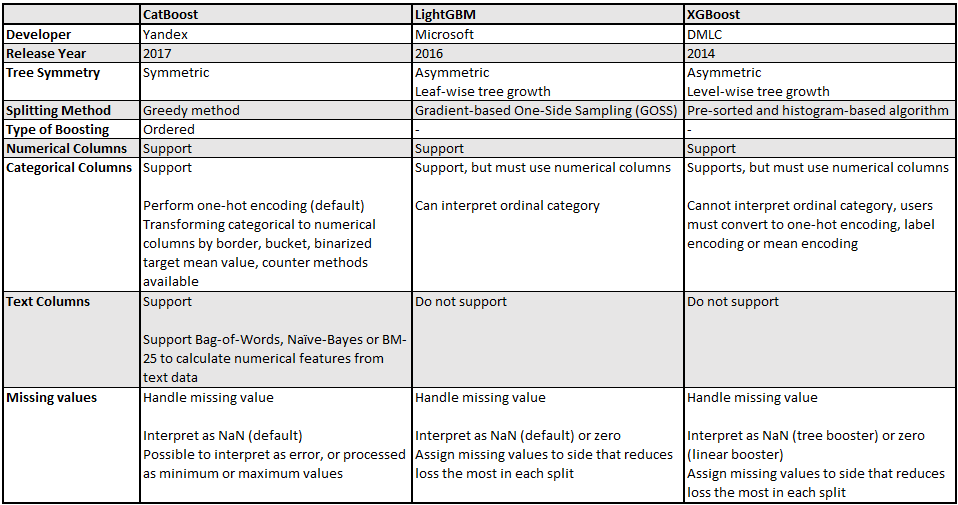

Табелата погоре е резиме на разликите помеѓу трите алгоритми.

# Модели за податоците енкодирани со различни техники за различни карактеристики


In [ ]:
features = diffenc_flats.columns.tolist()
features.remove('Цена')
features.remove('Unnamed: 0')
features

['Латитуда',
 'Лонгитуда',
 'Бројнасоби',
 'Квадратура',
 'ВоКуќа/ВоЗграда',
 'Состојба',
 'Опрема',
 'Лифт',
 'Бројнабањи',
 'Подрум',
 'Ориен_Југ',
 'Ориен_Југозапад',
 'Ориен_Југоисток',
 'Ориен_Запад',
 'Ориен_Исток',
 'Ориен_Север',
 'Ориен_Северозапад',
 'Ориен_Североисток',
 '1Гаража',
 '1Паркинг',
 '2Паркингместа',
 '3Паркингместа',
 'Гаража+1Паркинг',
 'Гаража+2Паркингместа',
 'Гаража+3Паркингместа',
 'Гаража+Повеќеод3паркингместа',
 'Повеќеод3паркингместа',
 '1Балкон',
 '1Тераса',
 '2Балкони',
 '3Балкони',
 'Повеќеод3балкони',
 'Тераса+1Балкон',
 'Тераса+2Балкони',
 '1кат',
 '2кат',
 '3кат',
 '4кат',
 '5кат',
 '6кат',
 '7кат',
 '8кат',
 '9кат',
 '>=10кат',
 'Поткровје',
 'Приземје',
 'ГреењеДрва',
 'ГреењеДруго',
 'ГреењеСтруја',
 'ГреењеЦентрално']

In [10]:
diffenc_flats.drop("Unnamed: 0", axis=1, inplace=True)
diffenc_flats.head(3)

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,ВоКуќа/ВоЗграда,Состојба,Опрема,Лифт,Бројнабањи,...,7кат,8кат,9кат,>=10кат,Поткровје,Приземје,ГреењеДрва,ГреењеДруго,ГреењеСтруја,ГреењеЦентрално
0,127000,41.998834,21.395788,4.0,89,1,4,3,1,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,95000,42.009423,20.971549,6.0,135,1,3,3,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,67500,41.987070,21.451929,2.0,45,1,4,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Поделба на базата на податоци во множество за тренирање и тестирање

In [11]:
x = diffenc_flats.loc[:, diffenc_flats.columns != 'Цена']
y = diffenc_flats['Цена']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Користење на GridSearchCV за hyperparameter tuning

GridSearchCV е техника за пребарување низ најдобрите вредности на параметрите од дадениот сет на параметри. Тоа е во основа метод на вкрстена валидација (cross validation). Се бара да се внесат моделот и параметрите. Се извлекуваат најдобрите вредности на параметрите и потоа се прават предвидувањата.

Model 1
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.05, 0.10, 0.15, 0.20, 0.25),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7],
                        'objective':['reg:linear', 'reg:squarederror'],
                        },
            cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=3)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
[14:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: -220229075.72135806
Best estimator: XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.15,
             min_child_weight=5)
Best parameters: {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 5, 'objective': 'reg:linear'}


In [12]:
model = XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.7, learning_rate = 0.15, min_child_weight=5,
    max_depth = 5, alpha = 2, n_estimators = 10, random_state=0)


model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 126.27922450256985
Mean Squared Error : 22777.74635424558
Mean Absolute Percentage error: 0.19896095076415496
R2_score:-0.22293112932815973


In [13]:
model.save_model("/content/drive/MyDrive/xgbRegressor1")

In [17]:
file_name = "/content/drive/MyDrive/xgb_reg_flats.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [15]:
xgb_model_loaded

XGBRegressor(alpha=2, colsample_bytree=0.7, learning_rate=0.15, max_depth=5,
             min_child_weight=5, missing=nan, n_estimators=10,
             objective='reg:squarederror')

In [ ]:
print(model.feature_importances_)

[0.02749244 0.02862551 0.09174035 0.4212368  0.         0.02098669
 0.03328987 0.05535548 0.14124559 0.0287209  0.         0.01644758
 0.01254731 0.         0.         0.00709437 0.         0.
 0.         0.00632469 0.         0.         0.         0.
 0.         0.         0.01024944 0.0054316  0.         0.00218745
 0.00793599 0.         0.         0.         0.         0.0010705
 0.         0.01493483 0.00828638 0.01767335 0.         0.
 0.         0.         0.         0.         0.00916391 0.00044654
 0.         0.0315124 ]


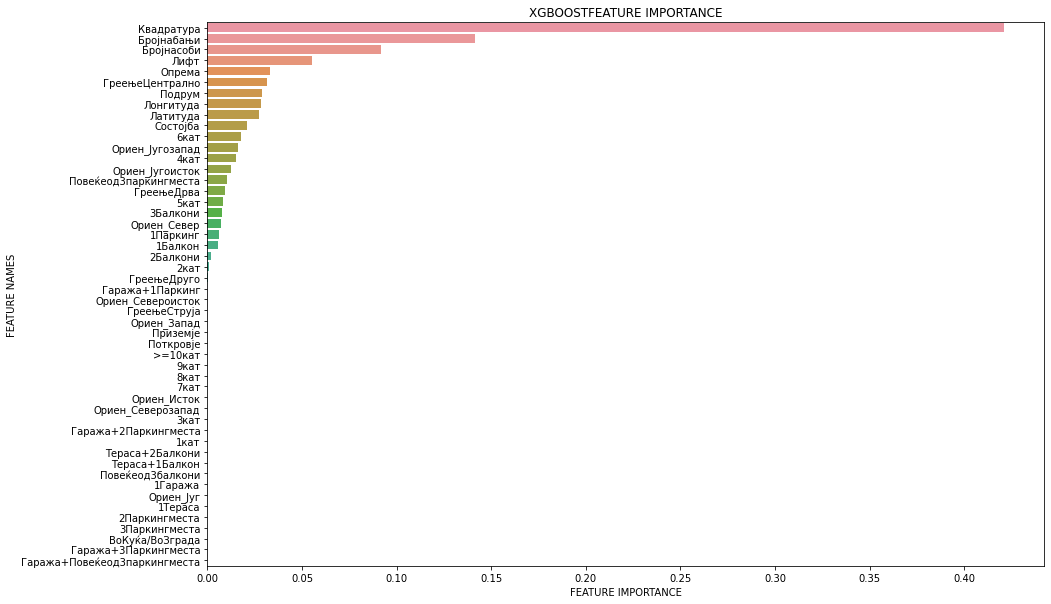

In [ ]:
plot_feature_importance(model.feature_importances_, features, 'XGBOOST')

<h1>SHAP - SHapley Additive exPlanations</h1>

SHAP е теоретски пристап на игри за објаснување на излезот од кој било модел на машинско учење. Ја поврзува оптималната распределба на кредити со локални објаснувања користејќи ги класичните вредности на Шепли од теоријата на игри и нивните поврзани проширувања

Вредностите на Шејпли се широко користен пристап од кооперативната теорија на игри кои доаѓаат со пожелни својства.

Додека SHAP го покажува придонесот или важноста на секоја карактеристика за предвидувањето на моделот, тој не го оценува квалитетот на самото предвидување.

Визуелизацијата подолу ги прикажува карактеристиките што го туркаат излезот на моделот од основната вредност (просечниот излез на моделот преку базата на податоци за обука) до излезот на моделот. Црвените карактеристики се оние кои го туркаат предвидувањето повисоко, додека сините карактеристики го туркаат предвидувањето пониско.


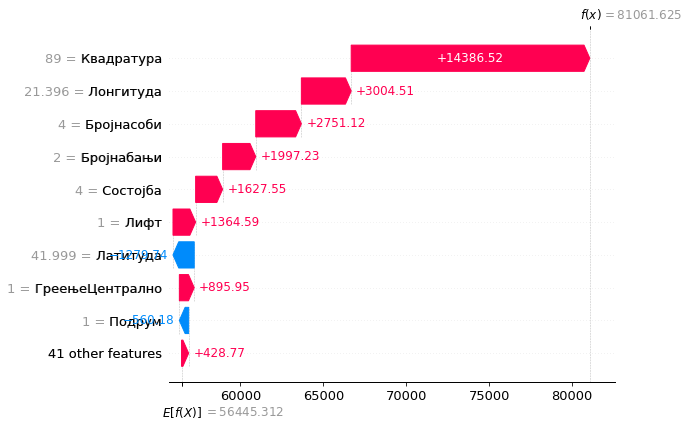

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0])

Во waterfall_plot погоре, x-оската ги има вредностите на целната (зависна) променлива која е цената на станови. x е избраното набљудување, f(x) е предвидената вредност на моделот, даден влез x и E[f(x)] е очекуваната вредност на целната променлива, или со други зборови, средната вредност на сите предвидувања (средна (модел.предвиди(X))).

Вредноста SHAP за секоја карактеристика во оваа опсервација е дадена со должината на лентата. Во горниот пример, Latitude има SHAP вредност од -41,9, Longitude има SHAP од +21,39 и така натаму. Збирот на сите SHAP вредности ќе биде еднаков на E[f(x)] — f(x).

Апсолутната вредност на SHAP ни покажува колку една карактеристика влијаела на предвидувањето, така што Longitude најмногу придонел, MedInc втората, AveOccup третата, а Популацијата била карактеристиката со најмал придонес во предвидувањето.

Овие вредности на SHAP важат само за ова набљудување. Со други точки на податоци, SHAP вредностите ќе се променат. Со цел да се разбере важноста или придонесот на карактеристиките за целата база на податоци, може да се користи друг plot, beeswarm plot:

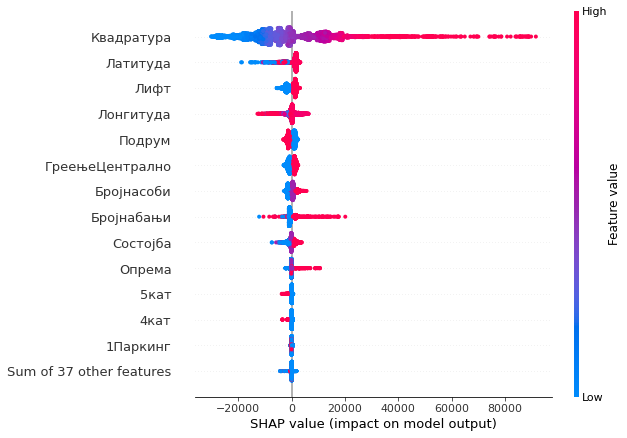

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

За да добиеме преглед за тоа кои карактеристики се најважни за моделот, можеме да ги нацртаме SHAP вредностите на секоја карактеристика за секој примерок. Заплетот подолу ги сортира карактеристиките според збирот на големини на SHAP вредности кај сите примероци и користи SHAP вредности за да ја прикаже дистрибуцијата на влијанијата што секоја карактеристика ги има на излезот од моделот. Бојата ја претставува вредноста на карактеристиката (црвено високо, сино ниско). Ова открива на пример дека високата вредност за Квадратура ја зголемува предвидената цена на домот.

Можете да изберете да се прикажат само најважните карактеристики на резимето со max_display.

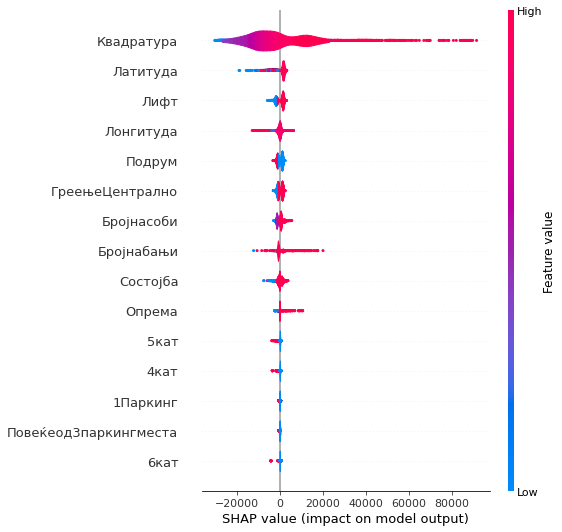

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=15)

Го користиме shap.plots.bar(shap_values) за да создадеме глобална мерка за важноста на карактеристиката


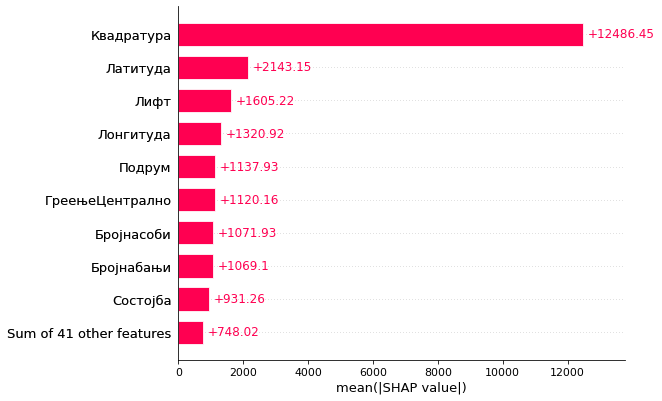

In [ ]:
shap.plots.bar(shap_values)

Model 2
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.10, 0.13, 0.15, 0.18, 0.20),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 6, 7],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7, 0.78],
                        'objective':['reg:squarederror'],
                        'n_estimators': [5, 10, 15, 20],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits
Best score: -11115.466004243362
Best estimator: XGBRegressor(colsample_bytree=0.7, learning_rate=0.18, max_depth=8,
             min_child_weight=5, n_estimators=20, objective='reg:squarederror')
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.18, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 20, 'objective': 'reg:squarederror', 'random_state': 0}


In [16]:
model2 = XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.7, learning_rate = 0.18, min_child_weight=5,
    max_depth = 8, alpha = 2, n_estimators = 20, random_state=0)


model2.fit(X_train, Y_train)
y_pred = model2.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 100.58962147244726
Mean Squared Error : 15063.541041944529
Mean Absolute Percentage error: 0.1425290434565878
R2_score:0.6929452669829157


In [18]:
file_name = "/content/drive/MyDrive/xgb_reg2_flats.pkl"

# save
pickle.dump(model2, open(file_name, "wb"))

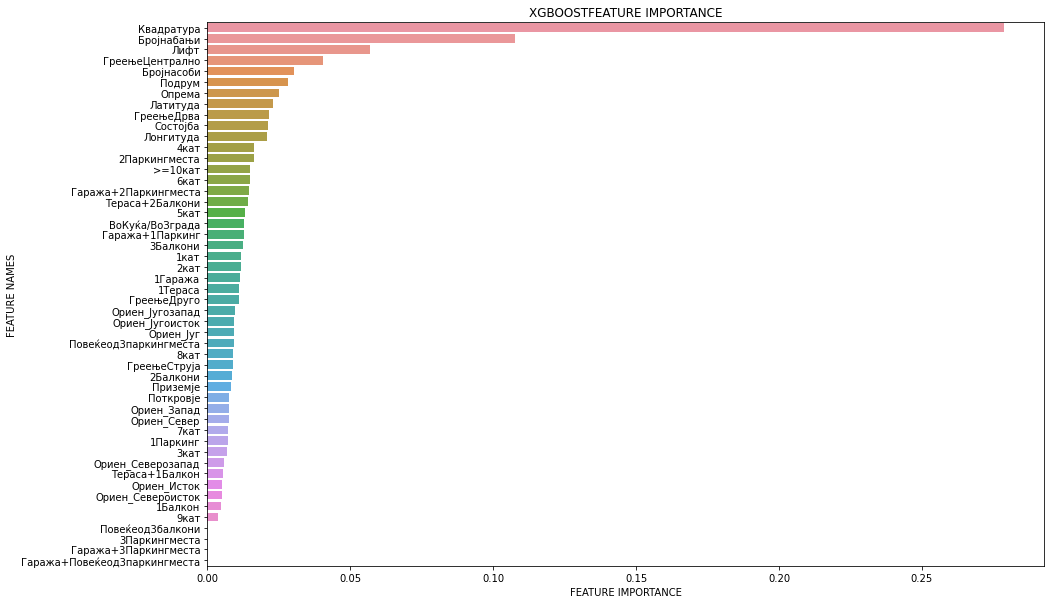

In [ ]:
plot_feature_importance(model2.feature_importances_, features, 'XGBOOST')

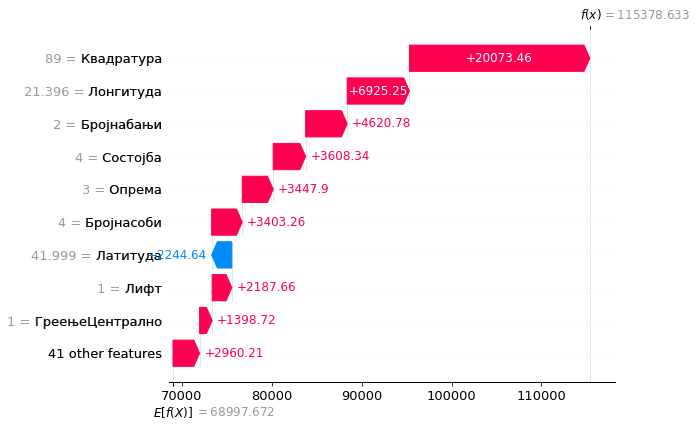

In [ ]:
explainer = shap.Explainer(model2)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

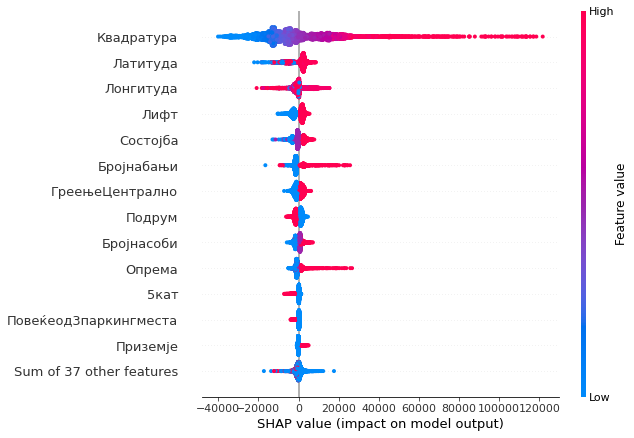

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

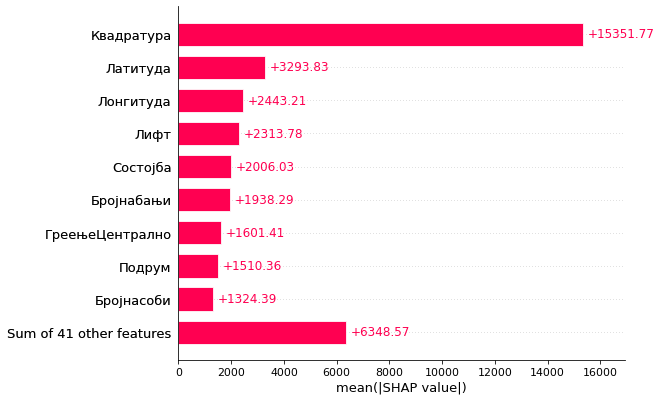

In [ ]:
shap.plots.bar(shap_values)

Model 3
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.15, 0.16, 0.17, 0.18, 0.19, 0.20),
                        "max_depth": [ 5, 6, 7, 8],
                        "min_child_weight": [ 1, 3, 5, 6, 7],
                        "colsample_bytree":[ 0.6, 0.7, 0.72, 0.78],
                        'objective':['reg:squarederror'],
                        'n_estimators': [10, 15, 20, 25],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits
Best score: -11021.345848460895
Best estimator: XGBRegressor(colsample_bytree=0.6, learning_rate=0.2, max_depth=6,
             min_child_weight=7, n_estimators=25, objective='reg:squarederror')
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 25, 'objective': 'reg:squarederror', 'random_state': 0}


In [19]:
model3 = XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.6, learning_rate = 0.2, min_child_weight=7,
    max_depth = 6, alpha = 2, n_estimators = 25, random_state=0)


model3.fit(X_train, Y_train)
y_pred = model3.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 101.00920366171289
Mean Squared Error : 15095.220601535199
Mean Absolute Percentage error: 0.14681820816688568
R2_score:0.6987060759689898


In [20]:
file_name = "/content/drive/MyDrive/xgb_reg3_flats.pkl"

# save
pickle.dump(model3, open(file_name, "wb"))

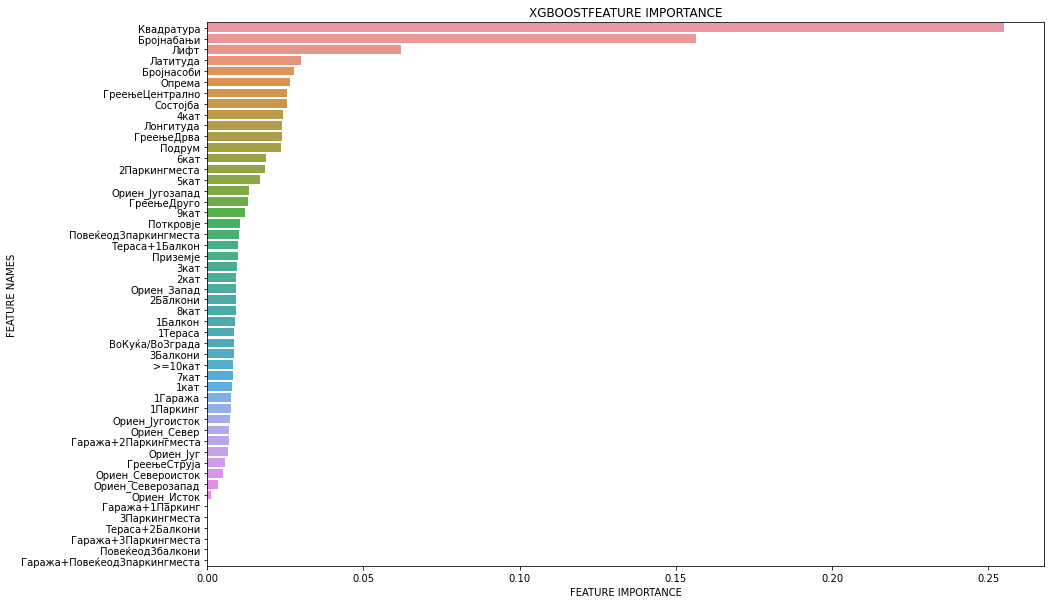

In [ ]:
plot_feature_importance(model3.feature_importances_, features, 'XGBOOST')

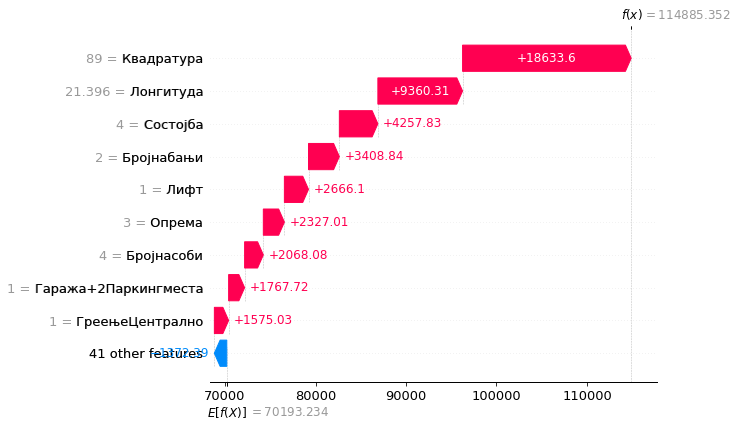

In [ ]:
explainer = shap.Explainer(model3)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

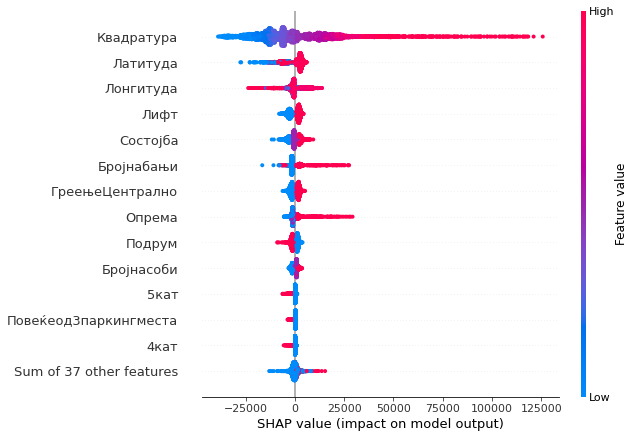

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

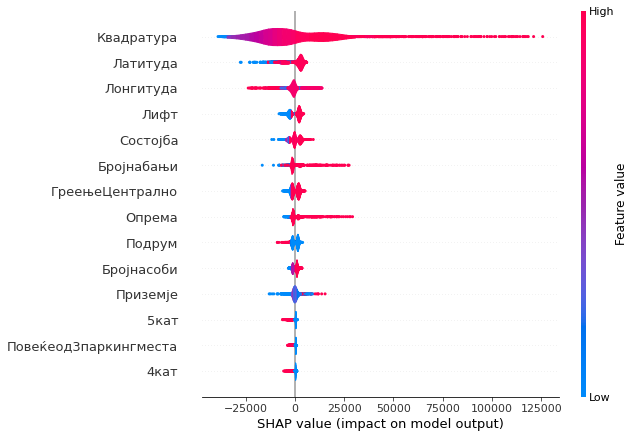

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=14)

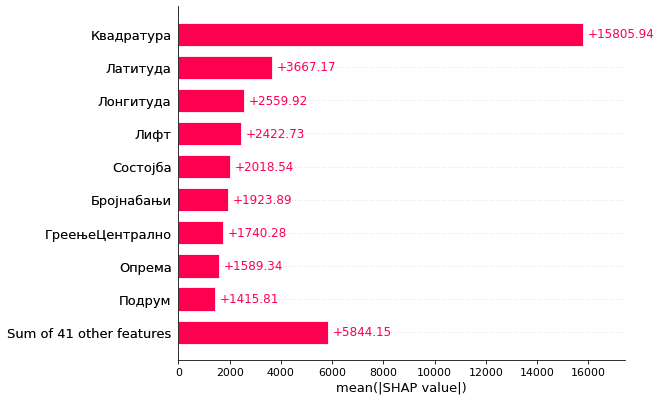

In [ ]:
shap.plots.bar(shap_values)

Model 4
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.16, 0.18, 0.20, 0.21, 0.22),
                        "max_depth": [ 5, 6, 7, 8],
                        "min_child_weight": [ 5, 6, 7, 8],
                        "colsample_bytree":[ 0.5, 0.6, 0.65, 0.7],
                        'objective':['reg:squarederror'],
                        'n_estimators': [15, 20, 25, 30],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits
Best score: -253159728.37090945
Best estimator: XGBRegressor(colsample_bytree=0.6, learning_rate=0.21, max_depth=5,
             min_child_weight=6, n_estimators=30, objective='reg:squarederror')
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.21, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 30, 'objective': 'reg:squarederror', 'random_state': 0}


In [21]:
model4 = XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.6, learning_rate = 0.21, min_child_weight=6,
    max_depth = 5, alpha = 2, n_estimators = 30, random_state=0)


model4.fit(X_train, Y_train)
y_pred = model4.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(y_pred, Y_test)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 101.73898046047593
Mean Squared Error : 15150.62883133618
Mean Absolute Percentage error: 0.14469813006448773
R2_score:0.7005196676974701


In [22]:
file_name = "/content/drive/MyDrive/xgb_reg4_flats.pkl"
# save
pickle.dump(model4, open(file_name, "wb"))

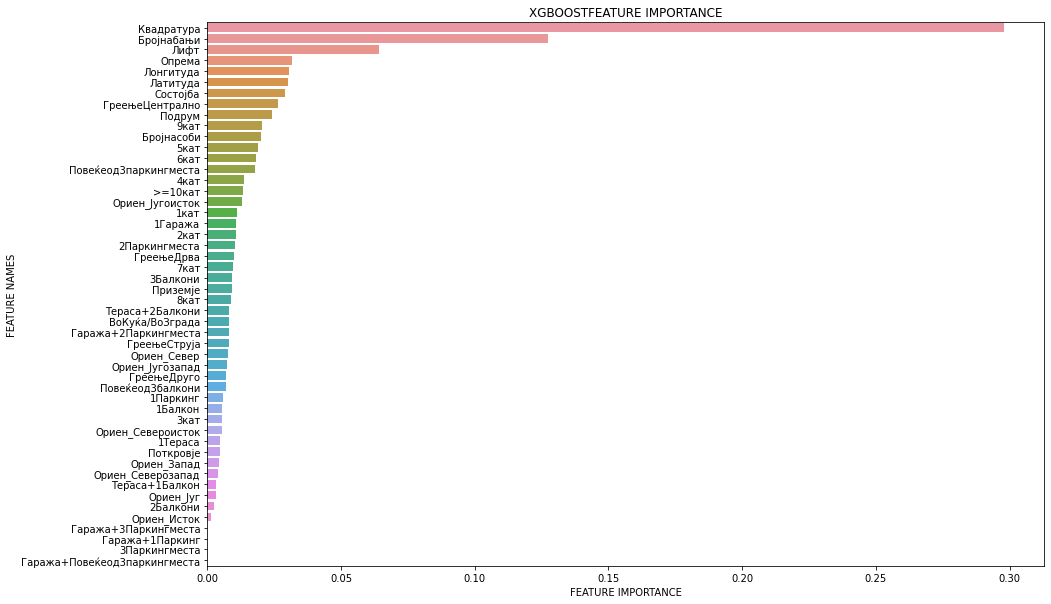

In [ ]:
plot_feature_importance(model4.feature_importances_, features, 'XGBOOST')

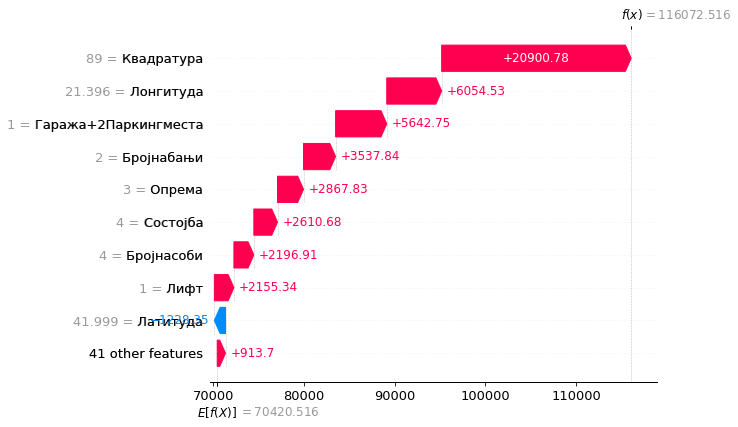

In [ ]:
explainer = shap.Explainer(model4)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

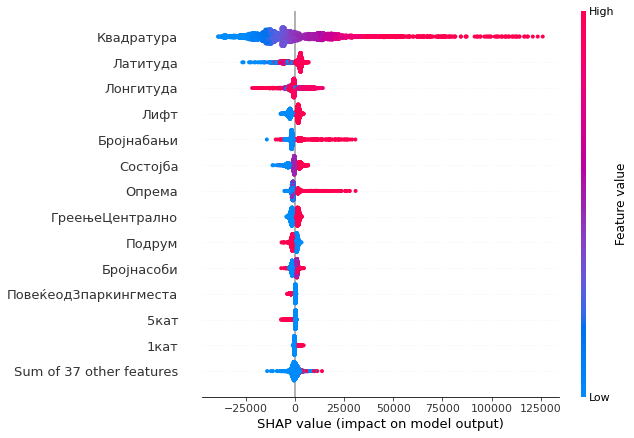

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

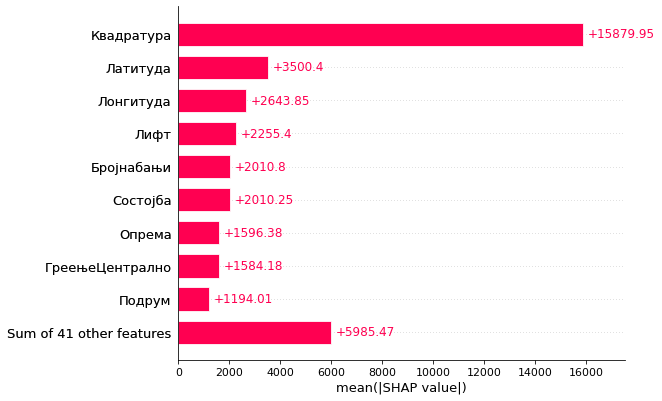

In [ ]:
shap.plots.bar(shap_values)

Model 5
--

<h2>XGBRegressor + KFold + RandomizedSearch</h2>

За овој модел се користи XGBRegressor заедно со KFold cross validation, и наместо GridSearch правам RandomizedSearch.

K-Fold Cross-Validation е постапка за повторно земање примероци што се користи за евалуација на моделите за машинско учење на ограничен број на податоци (мало податочно множество). Постапката има еден параметар наречен k, кој се однесува на бројот на групи на кои треба да се подели даден примерок на податоци. Како таква, постапката често се нарекува k-fold cross-validation. Кога ќе се избере специфична вредност за k, таа може да се користи на местото на k во референцата за моделот, како на пример k=5 да стане 5-кратна вкрстена валидација.

RandomizedSearch е техника каде случајните комбинации на хиперпараметрите се користат за да се најде најдоброто решение за изградениот модел. Слично е на GridSearch, а сепак се покажа дека дава подобри резултати споредбено.

In [ ]:
y = diffenc_flats['Цена']
X = diffenc_flats.loc[:, diffenc_flats.columns != 'Цена']

In [ ]:
cross_val_score(model, X, y, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', n_jobs=-1)

array([-44154.2421875 , -12144.9453125 , -26627.67578125, ...,
         -536.79882812,  -4731.22851562,  -5257.13671875])

In [ ]:
cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


array([-23232.74936235, -17973.31269933, -15365.17799736, -11482.09099284,
       -13115.40906913])

Обука на xgboost регресор со 5-кратна вкрстена валидација за оптимизирање на негативната просечна апсолутна грешка користејќи рандомизирано пребарување за оптимизација на хиперпараметри.

In [ ]:
xgb = XGBRegressor()

param_dist = {"learning_rate": (0.05, 0.10, 0.15, 0.20, 0.25, 0.30),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7, 0.8],
                        'objective':['reg:linear', 'reg:squarederror'],
                        }
reg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'neg_mean_absolute_error', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(x))
score = 0.0
kf = 1

for train_index, test_index in folds.split(x):
    X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    reg.fit(X_train, y_train)

    estimators.append(reg.best_estimator_)
    results[test_index] = reg.predict(X_test)
    score += np.sqrt(mean_absolute_error(y_test, results[test_index]))
    print("Mean Absolute error for fold ", kf, "is: ", np.sqrt(mean_absolute_error(y_test, results[test_index])))
    kf += 1
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:15:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute error for fold  1 is:  100.36364798525513
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:16:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute error for fold  2 is:  97.4240374579809
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:16:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute error for fold  3 is:  98.61240332328293
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  4 is:  101.64648517376392
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  5 is:  99.5060470173059


In [ ]:
print("Best Random Estimators: ", estimators)

Best Random Estimators:  [XGBRegressor(colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=8,
             min_child_weight=3), XGBRegressor(colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=8,
             min_child_weight=3), XGBRegressor(colsample_bytree=0.4, gamma=0.1, max_depth=6, min_child_weight=7), XGBRegressor(colsample_bytree=0.8, gamma=0.0, max_depth=4, min_child_weight=5,
             objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.8, gamma=0.2, max_depth=6, min_child_weight=3,
             objective='reg:squarederror')]


In [ ]:
print("Cummulative Mean Absolute Error: ", score)

Cummulative Mean Absolute Error:  99.51052419151776


In [ ]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

Model 6
--

<h2>XGBRegressor + KFold + RandomizedSearch</h2>

In [ ]:
xgb = XGBRegressor()

param_dist = {"learning_rate": (0.15, 0.16, 0.17, 0.18, 0.19, 0.20),
                        "max_depth": [ 5, 6, 7, 8],
                        "min_child_weight": [ 1, 3, 5, 6, 7],
                        "colsample_bytree":[ 0.6, 0.7, 0.72, 0.78],
                        'objective':['reg:squarederror'],
                        'n_estimators': [10, 15, 20, 25],
                        'random_state' : [0]
                        }
reg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'neg_mean_absolute_error', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(x))
score = 0.0
kf = 1

for train_index, test_index in folds.split(x):
    X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    reg.fit(X_train, y_train)

    estimators.append(reg.best_estimator_)
    results[test_index] = reg.predict(X_test)
    score += np.sqrt(mean_absolute_error(y_test, results[test_index]))
    print("Mean Absolute error for fold ", kf, "is: ", np.sqrt(mean_absolute_error(y_test, results[test_index])))
    kf += 1
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  1 is:  99.52448012820257
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  2 is:  100.92589227149325
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  3 is:  101.78120316196097
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  4 is:  100.11655482692528
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  5 is:  98.01540803874245


In [ ]:
print("Cummulative Mean Absolute Error: ", score)

Cummulative Mean Absolute Error:  100.0727076854649


In [ ]:
print("Best Random Estimators: ", estimators)

Best Random Estimators:  [XGBRegressor(colsample_bytree=0.72, learning_rate=0.18, max_depth=7,
             n_estimators=25, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.6, learning_rate=0.17, max_depth=8,
             min_child_weight=6, n_estimators=25, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.6, learning_rate=0.17, max_depth=6,
             min_child_weight=5, n_estimators=25, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.7, learning_rate=0.2, max_depth=5,
             min_child_weight=6, n_estimators=25, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.7, learning_rate=0.16, max_depth=7,
             min_child_weight=6, n_estimators=25, objective='reg:squarederror')]


Model 7
--

<h2>CatBoostRegressor</h2>

In [ ]:
cbr = CatBoostRegressor()

gsc = GridSearchCV(
            estimator=cbr,
            param_grid={'iterations': [50, 100, 150, 200],
                        'learning_rate': [0.03, 0.1, 0.5, 0.10, 0.15],
                        'depth': [2, 4, 6, 8],
                        'l2_leaf_reg': [0.2, 0.5, 1, 3],
                        'loss_function': ['RMSE', 'MAE'],
                        'random_state' : [0],
                        'verbose': [3]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits
0:	learn: 20732.2986860	total: 49.5ms	remaining: 9.84s
3:	learn: 17259.0447961	total: 54.6ms	remaining: 2.68s
6:	learn: 15183.4539707	total: 59.3ms	remaining: 1.63s
9:	learn: 13840.3545538	total: 64ms	remaining: 1.22s
12:	learn: 13086.1356053	total: 68.7ms	remaining: 988ms
15:	learn: 12391.5337124	total: 73.3ms	remaining: 843ms
18:	learn: 11869.1862915	total: 80.6ms	remaining: 768ms
21:	learn: 11538.5662631	total: 85.4ms	remaining: 691ms
24:	learn: 11257.8073653	total: 89.8ms	remaining: 628ms
27:	learn: 11028.1915955	total: 94.4ms	remaining: 580ms
30:	learn: 10885.8351051	total: 99ms	remaining: 540ms
33:	learn: 10689.7675790	total: 104ms	remaining: 506ms
36:	learn: 10563.0159891	total: 108ms	remaining: 478ms
39:	learn: 10473.5658553	total: 113ms	remaining: 452ms
42:	learn: 10329.3617457	total: 118ms	remaining: 429ms
45:	learn: 10269.8884261	total: 122ms	remaining: 409ms
48:	learn: 10196.0642416	total: 127ms	remaining: 391m

In [23]:
model7 = CatBoostRegressor(iterations=200, l2_leaf_reg=3, learning_rate=0.15, 
                           loss_function='MAE', depth=4, random_state=0, verbose=False)

model7.fit(X_train, Y_train)
y_pred = model7.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 99.7848786016708
Mean Squared Error : 15119.430252567538
Mean Absolute Percentage error: 0.1392230767685031
R2_score:0.684616755396724


In [24]:
file_name = "/content/drive/MyDrive/cbr_reg_flats.pkl"
# save
pickle.dump(model7, open(file_name, "wb"))

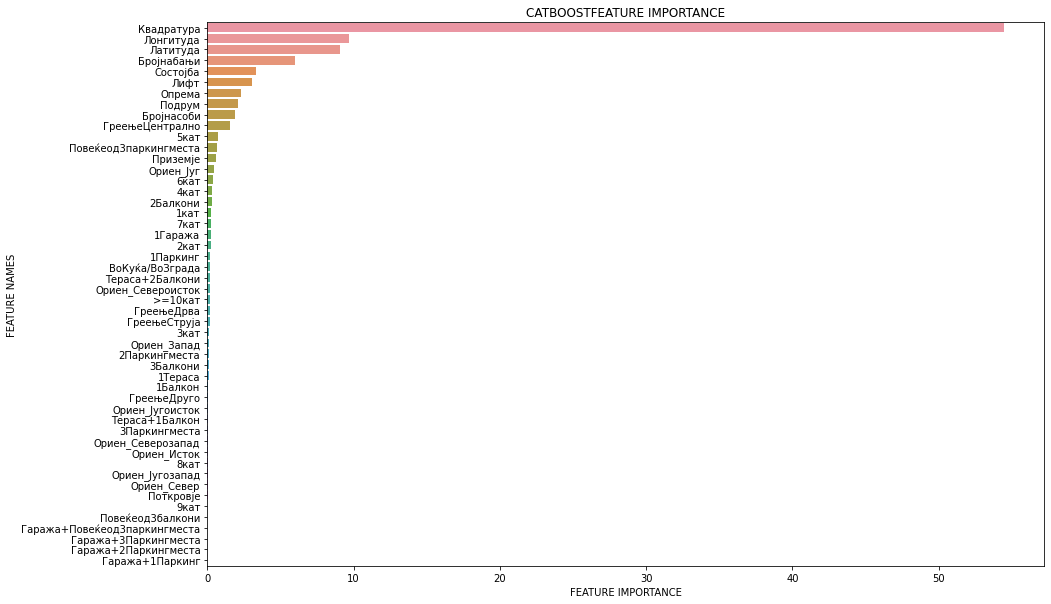

In [ ]:
plot_feature_importance(model7.feature_importances_, model7.feature_names_, 'CATBOOST')

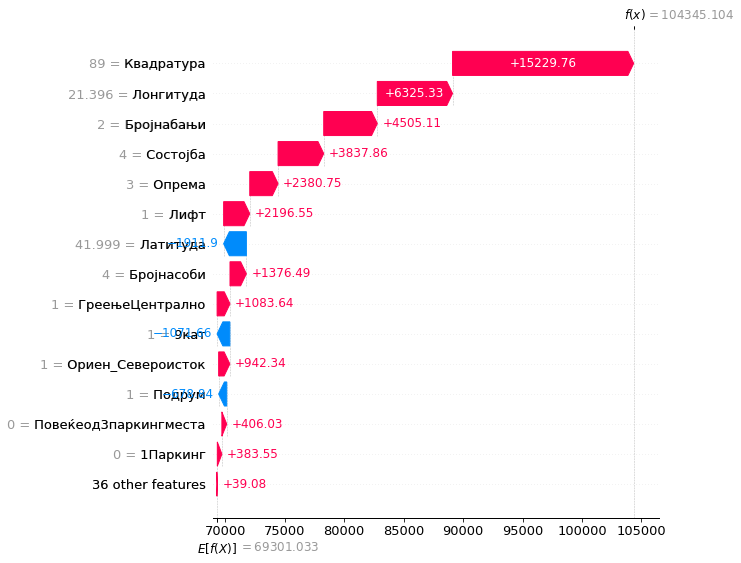

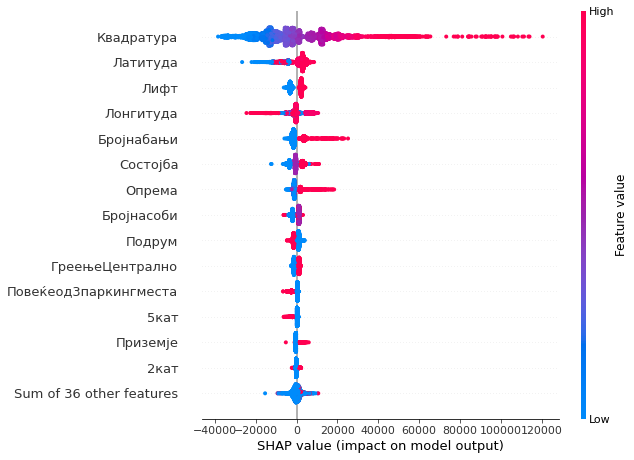

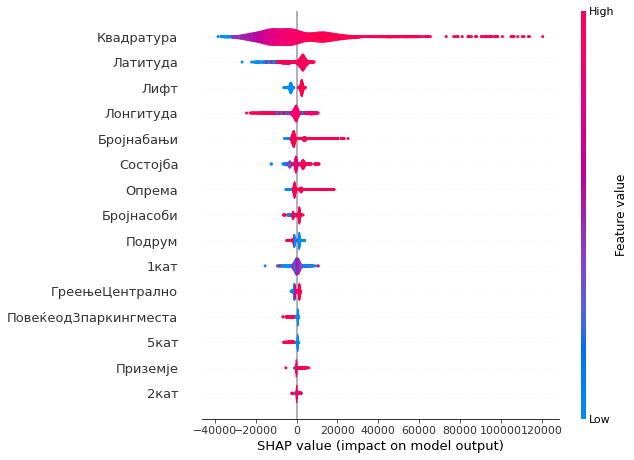

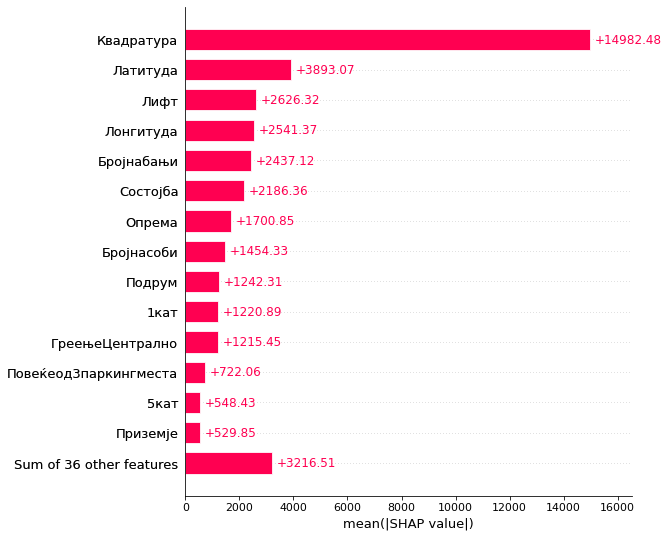

In [ ]:
explainer = shap.Explainer(model7)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0], max_display=15)
shap.plots.beeswarm(shap_values, max_display=15)
shap.summary_plot(shap_values, plot_type='violin', max_display=15)
shap.plots.bar(shap_values, max_display=15)

Model 8
--

<h2>LGBM</h2>

In [ ]:
lgbm = LGBMRegressor()

gsc = GridSearchCV(
            estimator=lgbm,
            param_grid={'num_leaves': [7, 14, 21, 28, 31, 50],
                        'learning_rate': [0.03, 0.05, 0.10, 0.15, 0.20],
                        'max_depth': [3, 4, 5, 6, 8],
                        'n_estimators': [50, 100, 150, 200, 500],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 750 candidates, totalling 2250 fits
Best score: -10836.104592159338
Best estimator: LGBMRegressor(max_depth=4, n_estimators=200, num_leaves=7, random_state=0)
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'num_leaves': 7, 'random_state': 0}


In [25]:
model8 = LGBMRegressor(learning_rate=0.1, max_depth=4, n_estimators=200,
                       num_leaves=7, random_state=0)

model8.fit(X_train, Y_train)
y_pred = model8.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 99.75221108376766
Mean Squared Error : 14678.915849097093
Mean Absolute Percentage error: 0.14223237133160868
R2_score:0.727816251122047


In [26]:
file_name = "/content/drive/MyDrive/lgbm_reg_flats.pkl"
# save
pickle.dump(model8, open(file_name, "wb"))

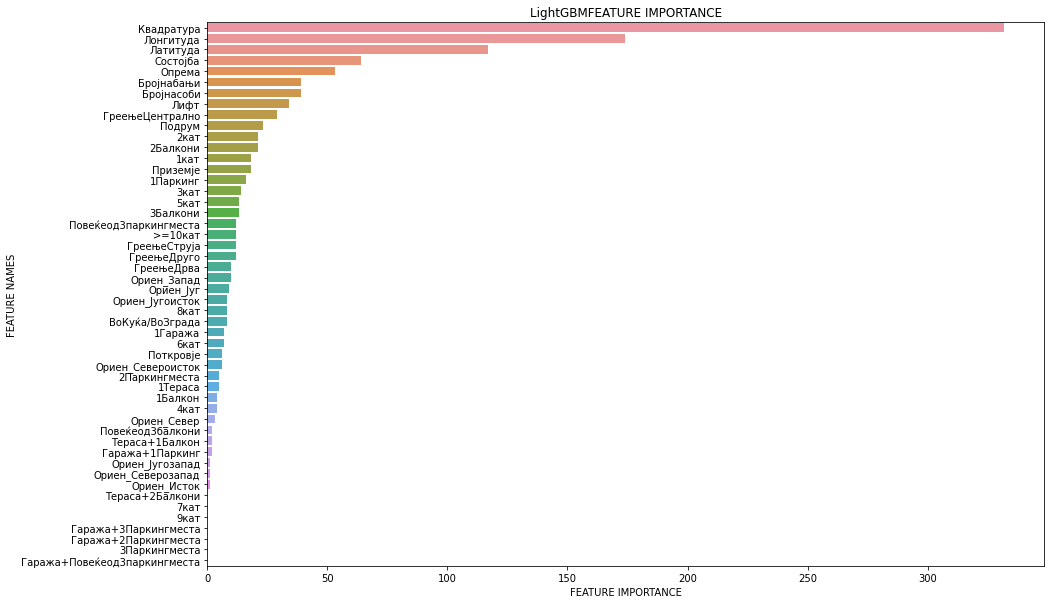

In [ ]:
plot_feature_importance(model8.feature_importances_, features, 'LightGBM')

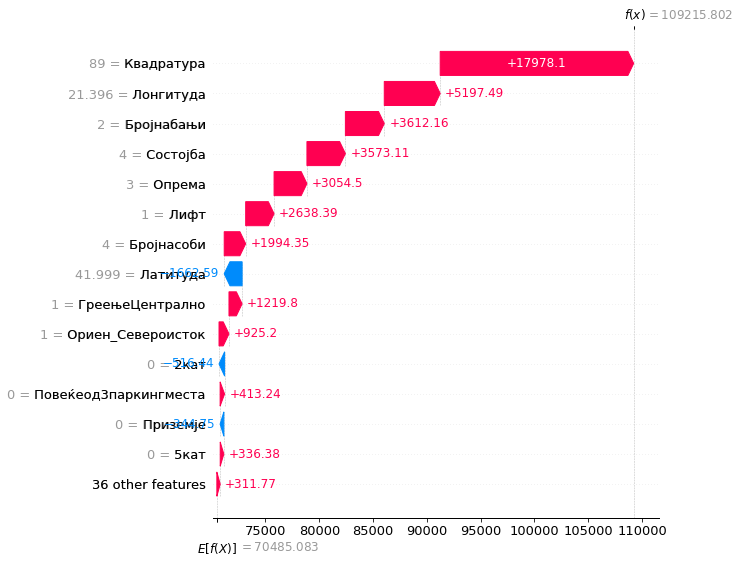

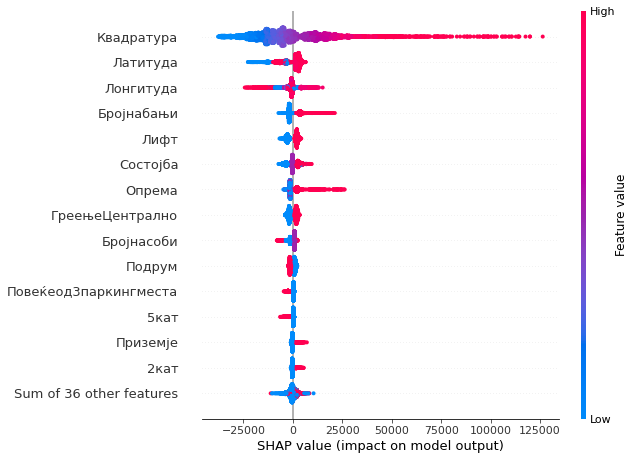

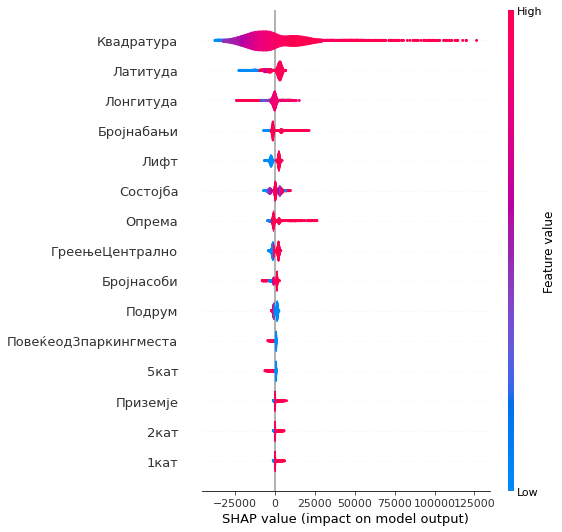

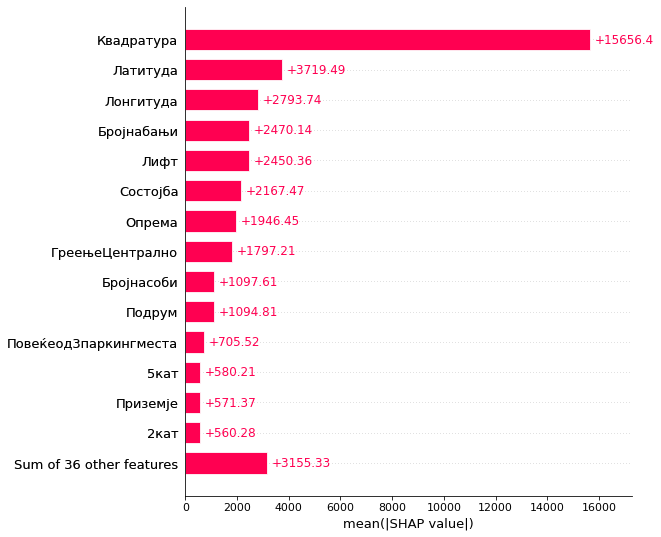

In [ ]:
explainer = shap.Explainer(model8)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0], max_display=15)
shap.plots.beeswarm(shap_values, max_display=15)
shap.summary_plot(shap_values, plot_type='violin', max_display=15)
shap.plots.bar(shap_values, max_display=15)

SUMMARY
--

In [ ]:
from sklearn import metrics
algorithms = []

algorithms.append(XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.7, learning_rate = 0.15, min_child_weight=5,
    max_depth = 5, alpha = 2, n_estimators = 10, random_state=0))

algorithms.append(XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.7, learning_rate = 0.18, min_child_weight=5,
    max_depth = 8, alpha = 2, n_estimators = 20, random_state=0))

algorithms.append(XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.6, learning_rate = 0.2, min_child_weight=7,
    max_depth = 6, alpha = 2, n_estimators = 25, random_state=0))

algorithms.append(XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.6, learning_rate = 0.21, min_child_weight=6,
    max_depth = 5, alpha = 2, n_estimators = 30, random_state=0))

algorithms.append(CatBoostRegressor(iterations=200, l2_leaf_reg=3, learning_rate=0.15, 
                           loss_function='MAE', depth=4, random_state=0, verbose=False))

algorithms.append(LGBMRegressor(learning_rate=0.1, max_depth=4, n_estimators=200,
                       num_leaves=7, random_state=0))

data = []

for algo in algorithms:

  algo.fit(X_train, Y_train)

  y_pred = algo.predict(X_test)

  data.append(({
        'Mean Absolute Error': np.sqrt(metrics.mean_absolute_error(y_pred, Y_test)),
        'Mean Absolute Percentage Error': metrics.mean_absolute_percentage_error(y_pred, Y_test),
        'R2 score': metrics.r2_score(y_pred, Y_test),
        'Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_pred, Y_test))
        }))
  

results = pd.DataFrame(data=data, columns=['Mean Absolute Error', 'Mean Absolute Percentage Error', 'R2 score',
                                           'Mean Squared Error'],
                       index=['XGBRegressor1', 'XGBRegressor2', 
                              'XGBRegressor3', 'XGBRegressor4', 
                              'CatBoostRegressor', 'LGBMRegressor'])

results

,Mean Absolute Error,Mean Absolute Percentage Error,R2 score,Mean Squared Error
XGBRegressor1,126.279225,0.271744,-0.222931,22777.746354
XGBRegressor2,100.589621,0.143335,0.692945,15063.541042
XGBRegressor3,101.009204,0.143765,0.698706,15095.220602
XGBRegressor4,101.738980,0.144698,0.700520,15150.628831
CatBoostRegressor,99.784879,0.140988,0.684617,15119.430253
LGBMRegressor,99.752211,0.138993,0.727816,14678.915849


Најдобри перформанси за податоците енкодирани со различни техники за различни карактеристики имаат моделите XGBRegressor2, CatBoostRegressor и LGBMRegressor. Модел 5 (xgboost+kfold+randomizedsearch) исто така има многу добри перформанси со Кумулативна средна апсолутна грешка од 99.51052419151776

# Модели за податоците енкодирани со One-Hot Encoding


In [27]:
onehoten = onehotenc_flats.loc[:, onehotenc_flats.columns != 'Unnamed: 0']
onehoten

,Цена,Латитуда,Лонгитуда,Бројнасоби,Квадратура,Греење_Друго,Греење_Нема,Греење_Соларнаенергија,Греење_Струја,Греење_Централно,...,Бројнапаркинг/гаража_Гаража+Повеќеод3паркингместа,Бројнапаркинг/гаража_Нема,Бројнапаркинг/гаража_Повеќеод3паркингместа,Ориентација_Југозапад,Ориентација_Југоисток,Ориентација_Запад,Ориентација_Исток,Ориентација_Север,Ориентација_Северозапад,Ориентација_Североисток
0,127000,41.998834,21.395788,4.0,89,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,95000,42.009423,20.971549,6.0,135,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67500,41.987070,21.451929,2.0,45,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,95000,41.987628,21.447906,3.0,99,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,52000,42.060063,21.450033,3.0,83,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,42500,42.009423,20.971549,3.0,80,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5827,21000,41.745515,22.193960,2.0,42,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5828,21500,41.745515,22.193960,2.0,42,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5829,34000,41.987070,21.451929,1.0,30,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [28]:
x = onehoten.loc[:, onehoten.columns != 'Цена']
y = onehotenc_flats['Цена']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
features = onehotenc_flats.columns.tolist()
features.remove('Цена')
features.remove('Unnamed: 0')
features

['Латитуда',
 'Лонгитуда',
 'Бројнасоби',
 'Квадратура',
 'Греење_Друго',
 'Греење_Нема',
 'Греење_Соларнаенергија',
 'Греење_Струја',
 'Греење_Централно',
 'Спрат_11кат',
 'Спрат_12кат',
 'Спрат_13кат',
 'Спрат_14кат',
 'Спрат_1кат',
 'Спрат_2кат',
 'Спрат_3кат',
 'Спрат_4кат',
 'Спрат_5кат',
 'Спрат_6кат',
 'Спрат_7кат',
 'Спрат_8кат',
 'Спрат_9кат',
 'Спрат_>15кат',
 'Спрат_Поткровје',
 'Спрат_Приземје',
 'Спрат_Сутеренстан',
 'Типнастанот_Вокуќа',
 'Состојба_Нов',
 'Состојба_Реновиран',
 'Состојба_Стар',
 'Опрема_Наместен',
 'Опрема_Полунаместен',
 'Опрема_Празен',
 'Лифт_Не',
 'Бројнабалкони_1Тераса',
 'Бројнабалкони_2Балкони',
 'Бројнабалкони_3Балкони',
 'Бројнабалкони_Нема',
 'Бројнабалкони_Повеќеод3балкони',
 'Бројнабалкони_Тераса+1Балкон',
 'Бројнабалкони_Тераса+2Балкони',
 'Бројнабалкони_Тераса+3Балкони',
 'Бројнабалкони_Тераса+Повеќеод3балкони',
 'Бројнабањи_2',
 'Бројнабањи_Повеќеод2',
 'Подрум_Не',
 'Бројнапаркинг/гаража_1Паркинг',
 'Бројнапаркинг/гаража_2Паркингместа',
 '

Model 1
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.05, 0.10, 0.15, 0.20, 0.25),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7],
                        'objective':['reg:linear', 'reg:squarederror'],
                        'n_estimators': [5, 10, 15, 20]
                        },
            cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 9600 candidates, totalling 28800 fits
[20:46:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: -241199116.8548343
Best estimator: XGBRegressor(colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8,
             min_child_weight=7, n_estimators=20)
Best parameters: {'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.25, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 20, 'objective': 'reg:linear'}


In [29]:
model_onehotenc = XGBRegressor(objective ='reg:squarederror', gamma = 0.0,
    colsample_bytree = 0.4, learning_rate = 0.25, min_child_weight=7, 
    max_depth = 8, alpha = 2, n_estimators = 20)


model_onehotenc.fit(X_train, Y_train)
y_pred = model_onehotenc.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 102.39594949231139
Mean Squared Error : 15992.887709444944
Mean Absolute Percentage error: 0.15378126205222523
R2_score:0.6228518306603885


In [30]:
file_name = "/content/drive/MyDrive/xgb_reg_one_hot_enc_flats.pkl"
# save
pickle.dump(model_onehotenc, open(file_name, "wb"))

In [ ]:
model_onehotenc.feature_importances_

array([0.01945796, 0.02221711, 0.026871  , 0.19460866, 0.01083968,
       0.00956651, 0.        , 0.0053885 , 0.01318693, 0.        ,
       0.00166929, 0.        , 0.        , 0.02084602, 0.01177493,
       0.00772397, 0.00930733, 0.00730494, 0.01355175, 0.00543297,
       0.00519795, 0.00488388, 0.        , 0.01338291, 0.00935697,
       0.        , 0.01804185, 0.02087897, 0.00419051, 0.04580474,
       0.0044718 , 0.00626933, 0.00895488, 0.06504332, 0.00299424,
       0.01045905, 0.04659368, 0.00490739, 0.01133992, 0.03012454,
       0.01328119, 0.        , 0.        , 0.03124503, 0.16261485,
       0.01121386, 0.00516886, 0.01119513, 0.01950311, 0.0055737 ,
       0.        , 0.        , 0.        , 0.00883563, 0.01130703,
       0.00453154, 0.00624248, 0.00186636, 0.00285013, 0.00433498,
       0.00292011, 0.00467258], dtype=float32)

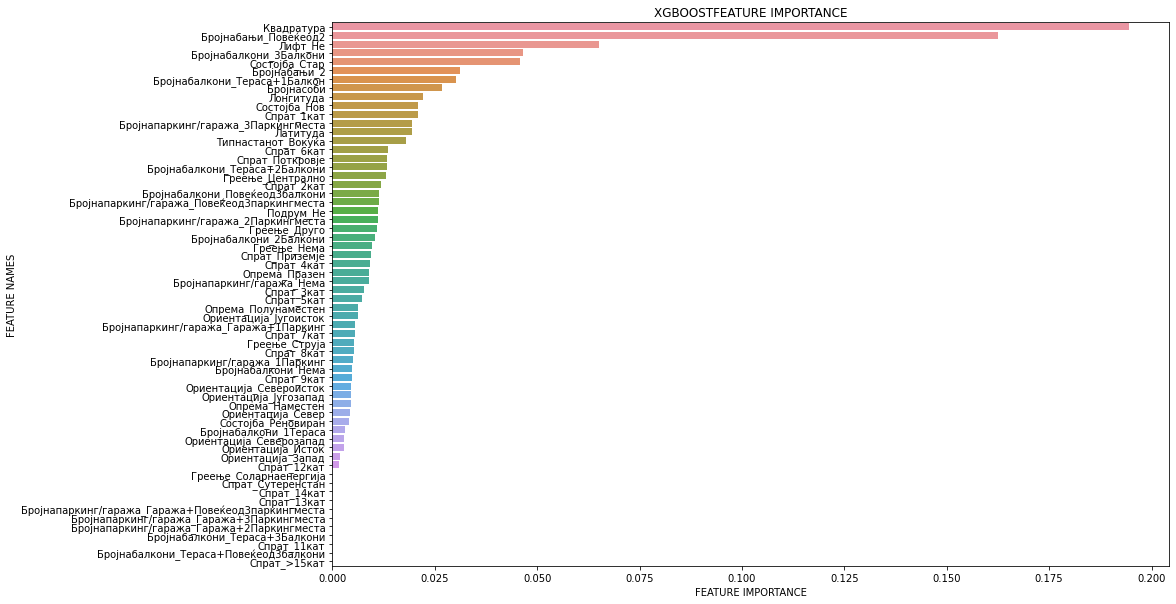

In [ ]:
plot_feature_importance(model_onehotenc.feature_importances_, features, 'XGBOOST')

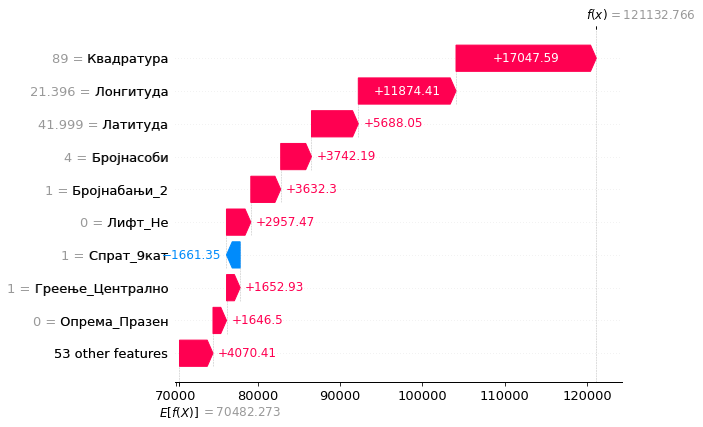

In [ ]:
explainer = shap.Explainer(model_onehotenc)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0])

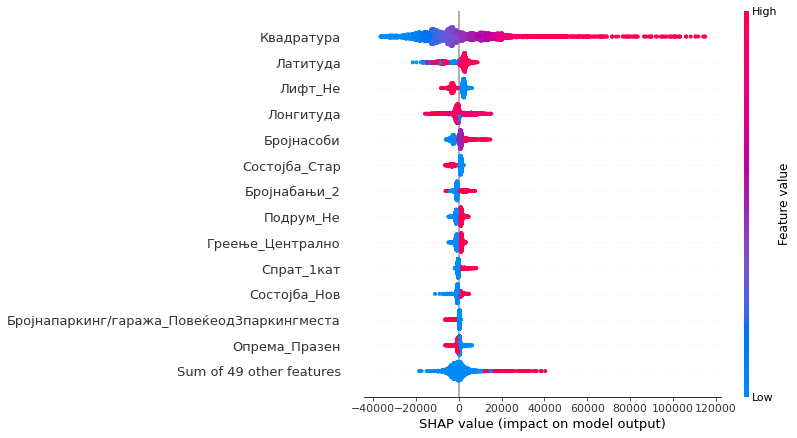

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

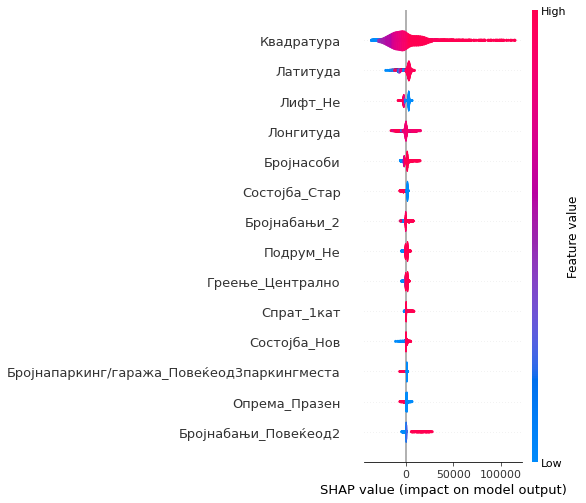

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=14)

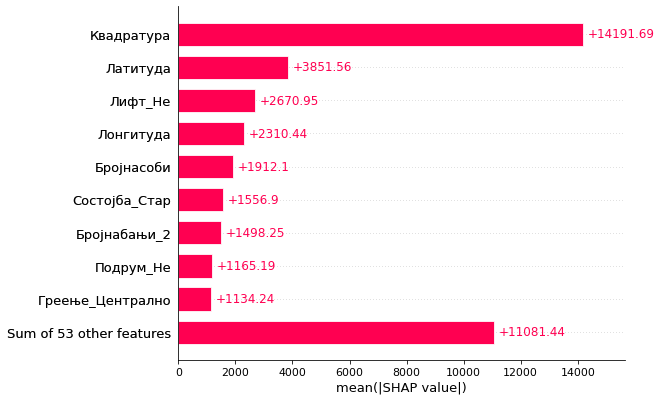

In [ ]:
shap.plots.bar(shap_values)

Model 2
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.10, 0.13, 0.15, 0.18, 0.20),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 6, 7],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7, 0.78],
                        'objective':['reg:squarederror'],
                        'n_estimators': [5, 10, 15, 20],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits
Best score: -10476.02858567218
Best estimator: XGBRegressor(colsample_bytree=0.7, learning_rate=0.2, max_depth=6,
             min_child_weight=6, n_estimators=20, objective='reg:squarederror')
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 20, 'objective': 'reg:squarederror', 'random_state': 0}


In [31]:
model_onehotenc2 = XGBRegressor(objective ='reg:squarederror', 
    colsample_bytree = 0.7, learning_rate = 0.2, min_child_weight=6,
    max_depth = 6, alpha = 2, n_estimators = 20, random_state=0)


model_onehotenc2.fit(X_train, Y_train)
y_pred = model_onehotenc2.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 102.19112019083377
Mean Squared Error : 15960.823833181774
Mean Absolute Percentage error: 0.15279418499666314
R2_score:0.6233908252989614


In [32]:
file_name = "/content/drive/MyDrive/xgb_reg_one_hot_enc2_flats.pkl"
# save
pickle.dump(model_onehotenc2, open(file_name, "wb"))

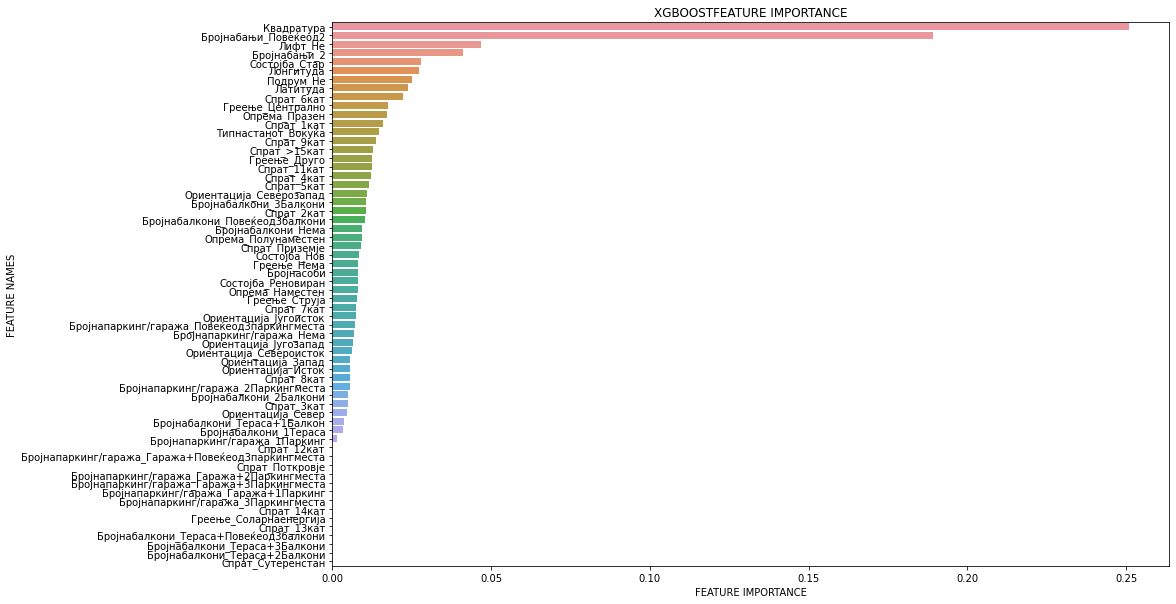

In [ ]:
plot_feature_importance(model_onehotenc2.feature_importances_, features, 'XGBOOST')

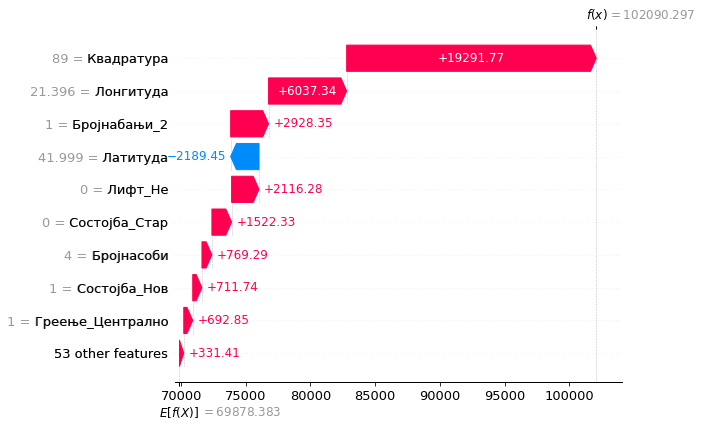

In [ ]:
explainer = shap.Explainer(model_onehotenc2)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0])

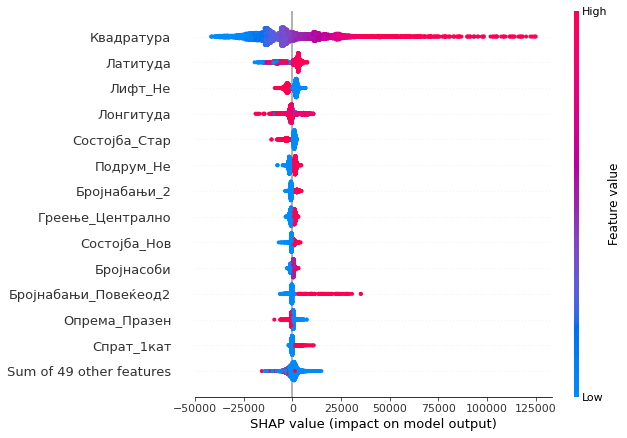

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

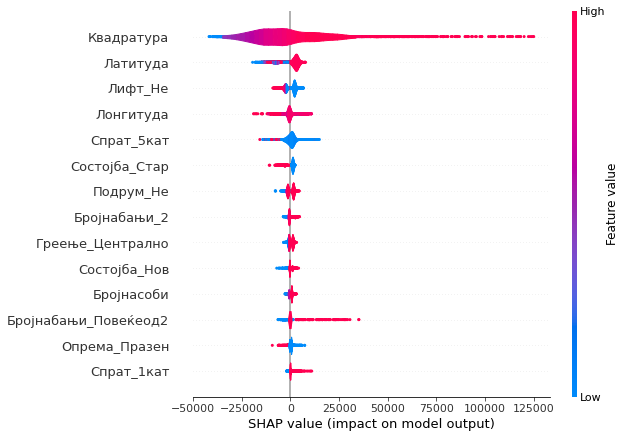

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=14)

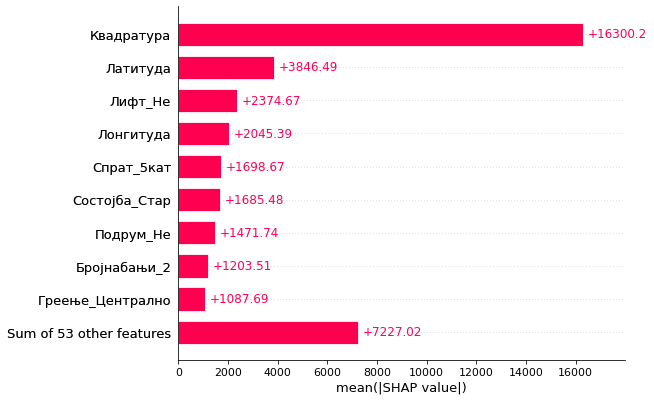

In [ ]:
shap.plots.bar(shap_values)

Model 3
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.18, 0.19, 0.20, 0.21, 0.22, 0.24, 0.25),
                        "max_depth": [ 5, 6, 7, 8],
                        "min_child_weight": [ 1, 3, 5, 6, 7],
                        "colsample_bytree":[ 0.4, 0.5, 0.6, 0.7, 0.78, 0.8],
                        'objective':['reg:squarederror'],
                        'n_estimators': [15, 20, 22, 25],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
Best score: -10309.302172525473
Best estimator: XGBRegressor(colsample_bytree=0.7, learning_rate=0.24, max_depth=5,
             n_estimators=25, objective='reg:squarederror')
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.24, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 25, 'objective': 'reg:squarederror', 'random_state': 0}


In [33]:
model_onehotenc3 = XGBRegressor(objective ='reg:squarederror', gamma = 0.0,
    colsample_bytree = 0.7, learning_rate = 0.24, min_child_weight=1, 
    max_depth = 5, alpha = 2, n_estimators = 25)


model_onehotenc3.fit(X_train, Y_train)
y_pred = model_onehotenc3.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 102.22577340078743
Mean Squared Error : 15806.232897178359
Mean Absolute Percentage error: 0.15516223120521216
R2_score:0.6283832573283145


In [34]:
file_name = "/content/drive/MyDrive/xgb_reg_one_hot_enc3_flats.pkl"
# save
pickle.dump(model_onehotenc3, open(file_name, "wb"))

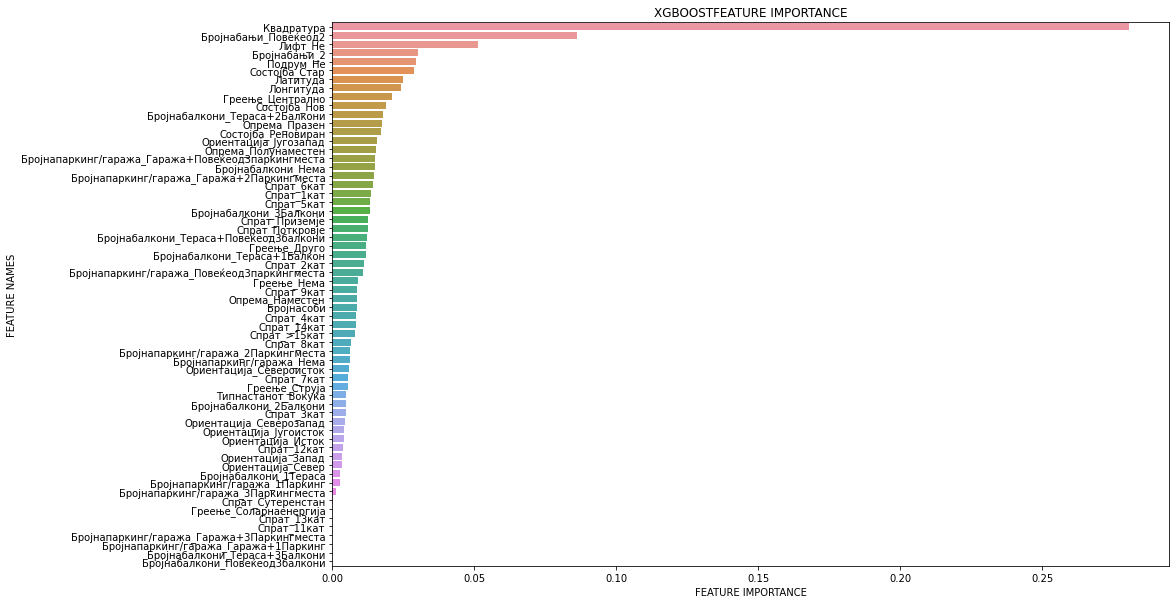

In [ ]:
plot_feature_importance(model_onehotenc3.feature_importances_, features, 'XGBOOST')

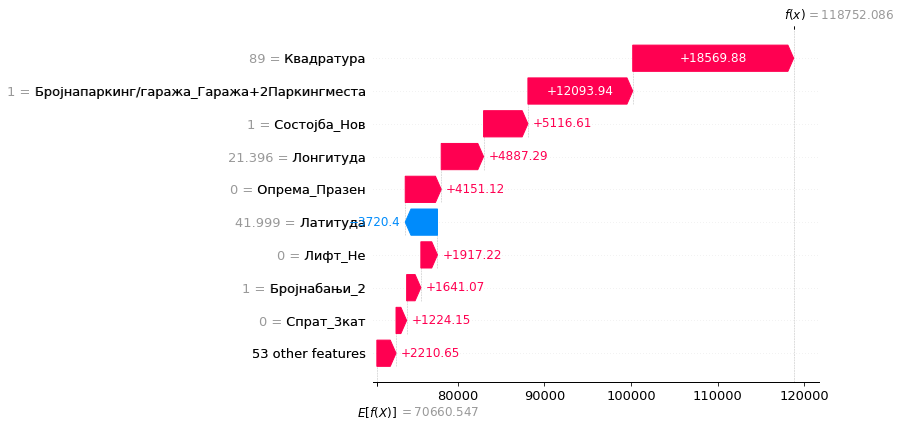

In [ ]:
explainer = shap.Explainer(model_onehotenc3)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0])

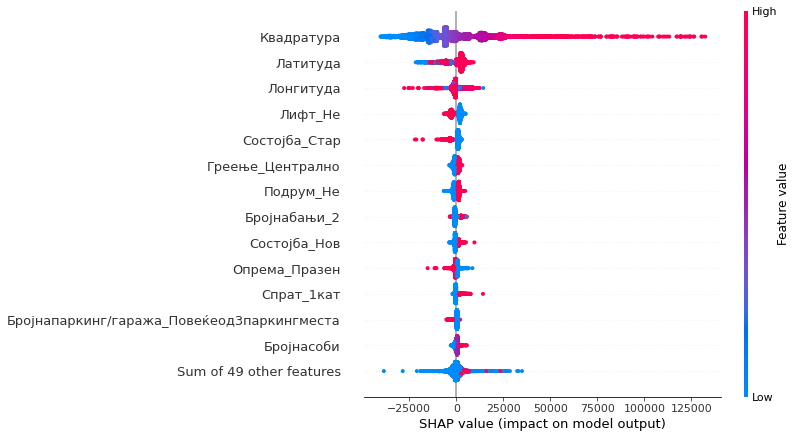

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

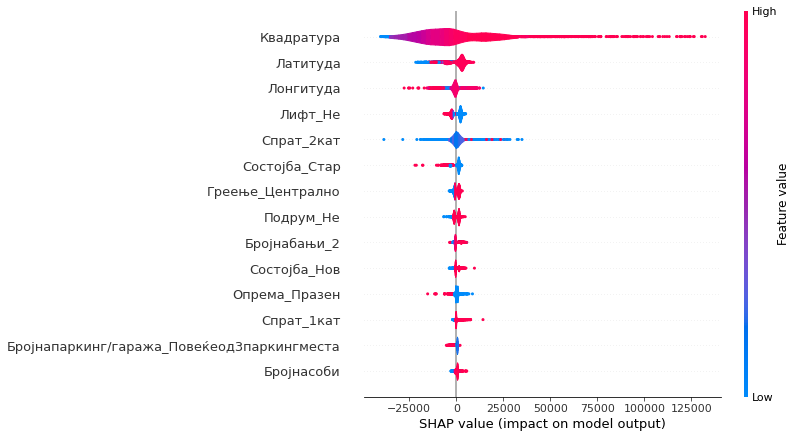

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=14)

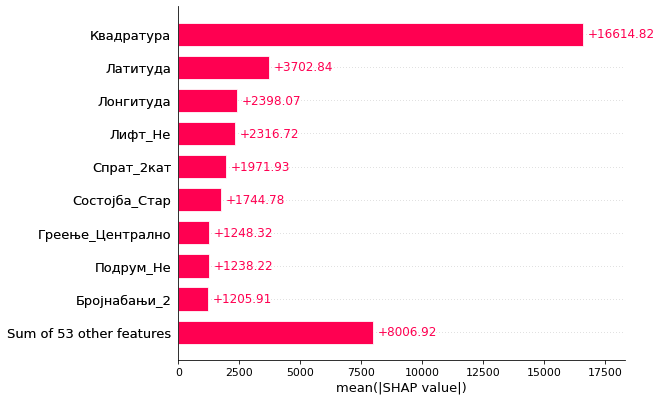

In [ ]:
shap.plots.bar(shap_values)

Model 4
--

<h2>XGBRegressor</h2>

In [ ]:
xgb = XGBRegressor()

gsc = GridSearchCV(
            estimator=xgb,
            param_grid={"learning_rate": (0.16, 0.18, 0.20, 0.21, 0.22, 0.25, 0.28, 0.30, 0.35),
                        "max_depth": [ 5, 6, 7, 8],
                        "min_child_weight": [ 5, 6, 7, 8],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7, 0.8],
                        'objective':['reg:squarederror'],
                        'n_estimators': [10, 15, 20, 25, 30],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
Best score: -230543671.53154853
Best estimator: XGBRegressor(colsample_bytree=0.8, learning_rate=0.22, max_depth=5,
             min_child_weight=7, n_estimators=30, objective='reg:squarederror')
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.22, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 30, 'objective': 'reg:squarederror', 'random_state': 0}


In [35]:
model_onehotenc4 = XGBRegressor(objective ='reg:squarederror', gamma = 0.0,
    colsample_bytree = 0.8, learning_rate = 0.22, min_child_weight=7, 
    max_depth = 5, alpha = 2, n_estimators = 30)


model_onehotenc4.fit(X_train, Y_train)
y_pred = model_onehotenc4.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 102.23572564929867
Mean Squared Error : 15936.063633514032
Mean Absolute Percentage error: 0.15438423108499202
R2_score:0.6442292129891192


In [36]:
file_name = "/content/drive/MyDrive/xgb_reg_one_hot_enc4_flats.pkl"
# save
pickle.dump(model_onehotenc4, open(file_name, "wb"))

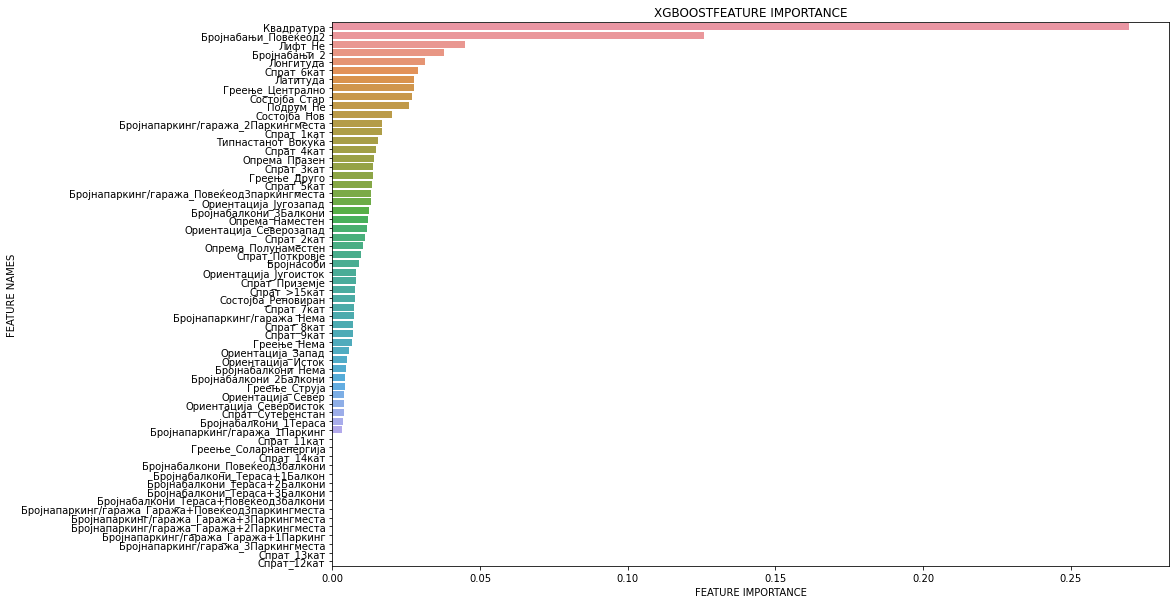

In [ ]:
plot_feature_importance(model_onehotenc4.feature_importances_, features, 'XGBOOST')

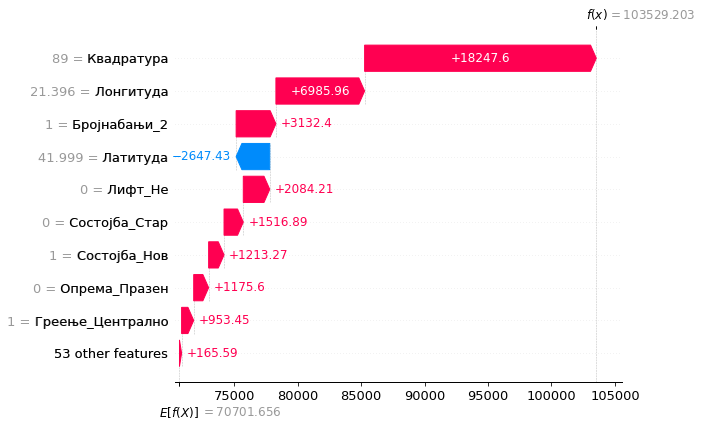

In [ ]:
explainer = shap.Explainer(model_onehotenc4)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0])

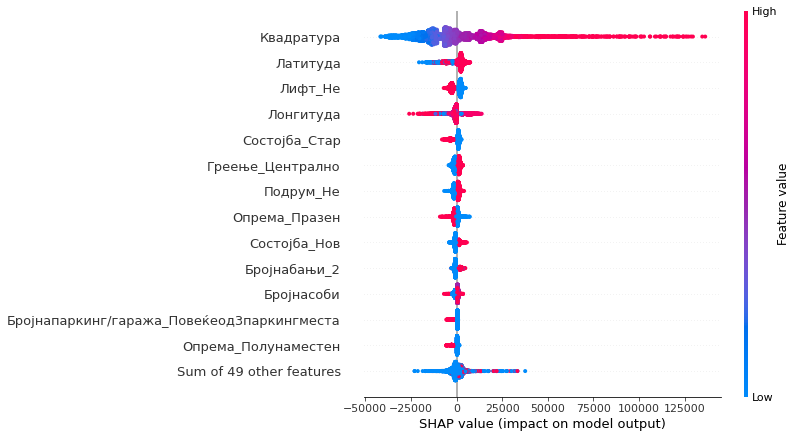

In [ ]:
shap.plots.beeswarm(shap_values, max_display=14)

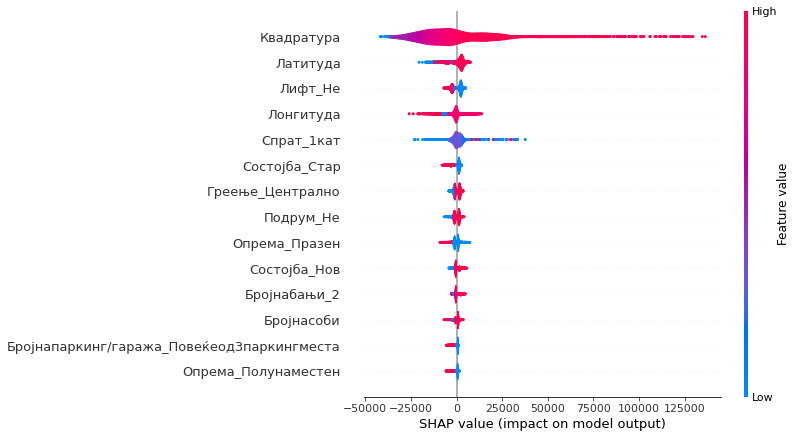

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', max_display=14)

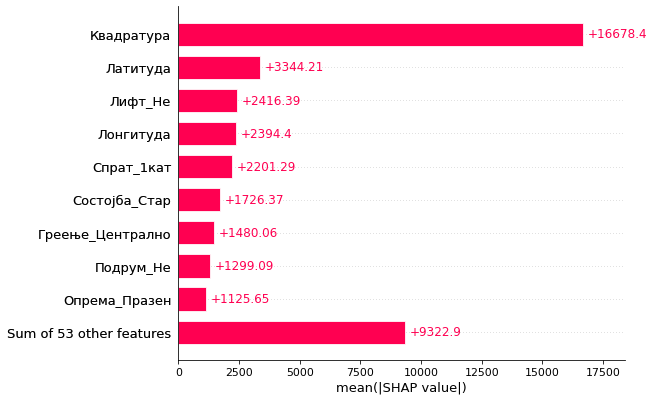

In [ ]:
shap.plots.bar(shap_values)

Model 5
--

<h2>CatBoostRegressor</h2>

In [ ]:
cbr = CatBoostRegressor()

gsc = GridSearchCV(
            estimator=cbr,
            param_grid={'iterations': [50, 100, 150, 200],
                        'learning_rate': [0.03, 0.05, 0.10, 0.15, 0.20, 0.25],
                        'depth': [2, 4, 6, 8],
                        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5],
                        'loss_function': ['RMSE', 'MAE'],
                        'random_state' : [0],
                        'verbose': [3]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits
0:	learn: 21225.3583604	total: 49.2ms	remaining: 9.8s
3:	learn: 18390.1075624	total: 57.7ms	remaining: 2.83s
6:	learn: 16272.9642836	total: 64.8ms	remaining: 1.79s
9:	learn: 14665.8505365	total: 72ms	remaining: 1.37s
12:	learn: 13735.4924642	total: 79.2ms	remaining: 1.14s
15:	learn: 12870.9239451	total: 86.4ms	remaining: 993ms
18:	learn: 12259.2649438	total: 93.8ms	remaining: 893ms
21:	learn: 11721.6446341	total: 101ms	remaining: 816ms
24:	learn: 11297.0241604	total: 108ms	remaining: 757ms
27:	learn: 11038.0047898	total: 115ms	remaining: 708ms
30:	learn: 10817.9581292	total: 122ms	remaining: 668ms
33:	learn: 10652.8945393	total: 130ms	remaining: 633ms
36:	learn: 10455.0255473	total: 137ms	remaining: 603ms
39:	learn: 10350.0760630	total: 153ms	remaining: 613ms
42:	learn: 10239.0581012	total: 161ms	remaining: 588ms
45:	learn: 10143.6024829	total: 168ms	remaining: 564ms
48:	learn: 10066.8122522	total: 175ms	remaining: 541ms
5

In [37]:
model_onehotenc5 = CatBoostRegressor(iterations=200, l2_leaf_reg=5, learning_rate=0.1, 
                           loss_function='MAE', depth=6, random_state=0, verbose=False)

model_onehotenc5.fit(X_train, Y_train)
y_pred = model_onehotenc5.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 101.253155291036
Mean Squared Error : 15902.32768176819
Mean Absolute Percentage error: 0.1478581367402707
R2_score:0.6273112664849456


In [38]:
file_name = "/content/drive/MyDrive/cbr_reg_flats_onehotenc.pkl"
# save
pickle.dump(model_onehotenc5, open(file_name, "wb"))

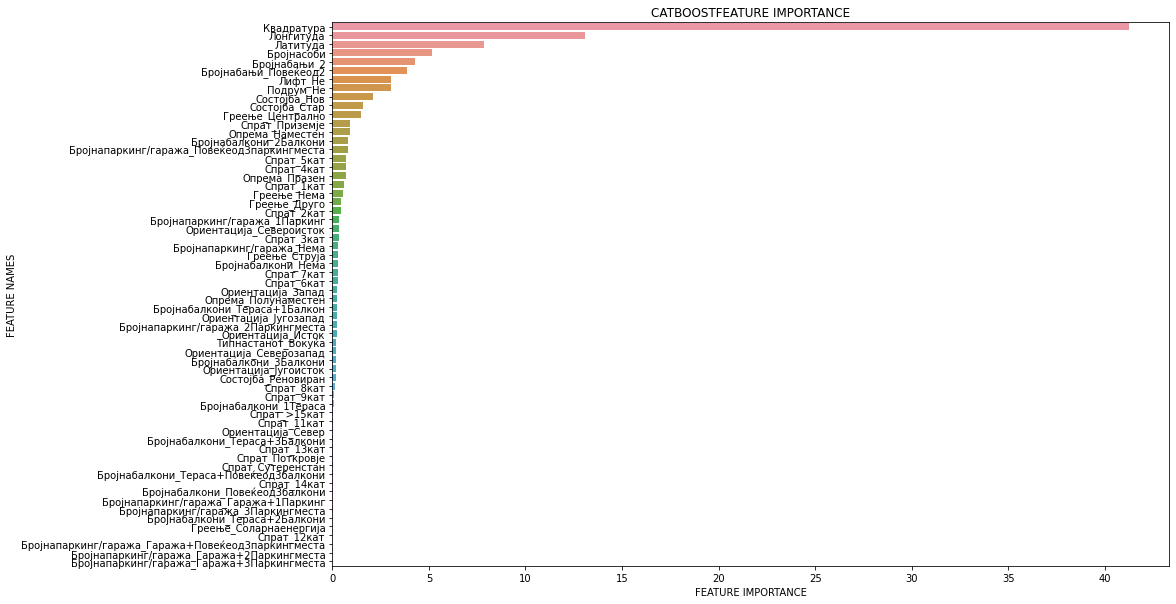

In [ ]:
plot_feature_importance(model_onehotenc5.feature_importances_, model_onehotenc5.feature_names_, 'CATBOOST')

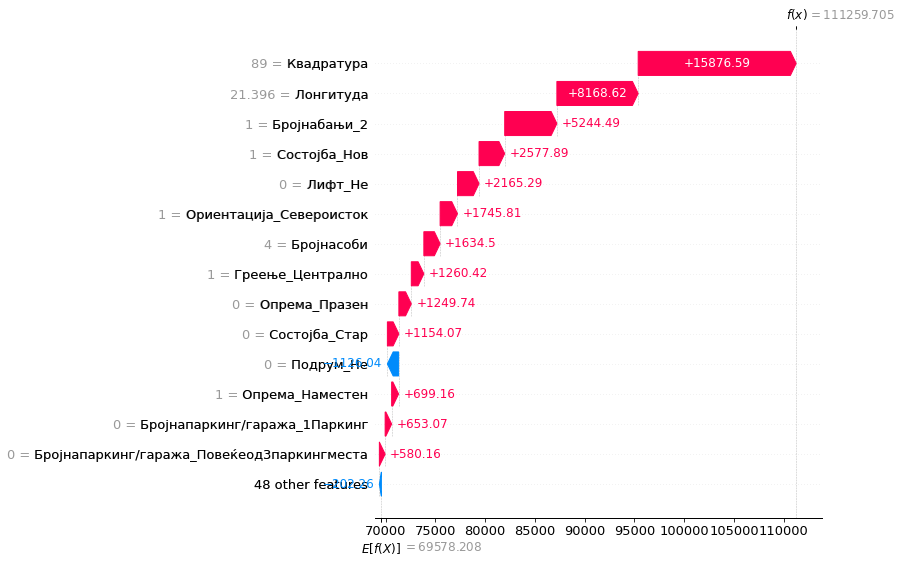

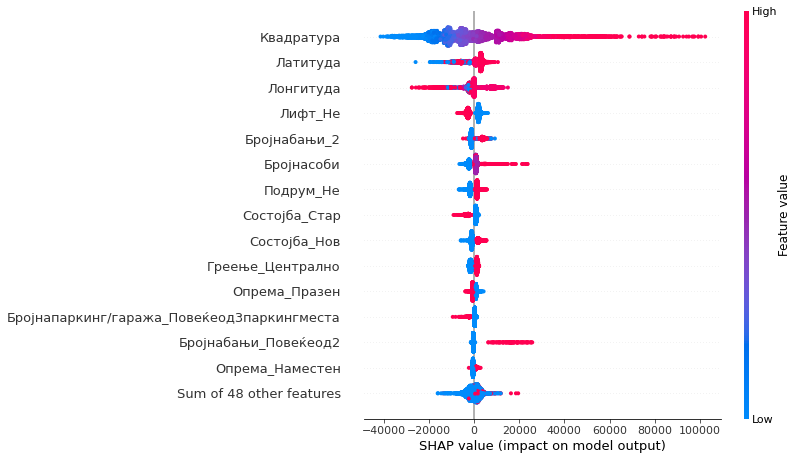

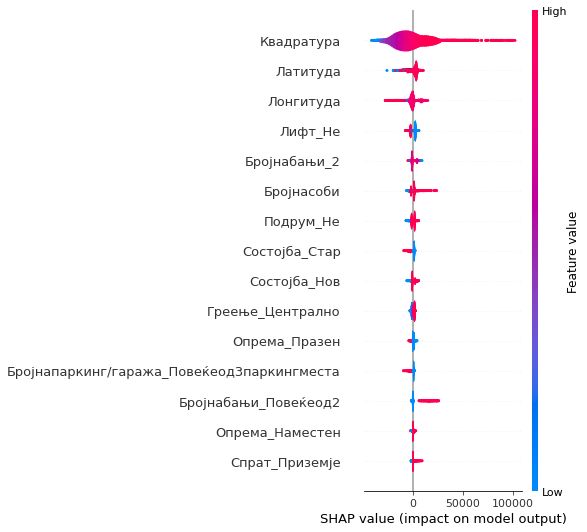

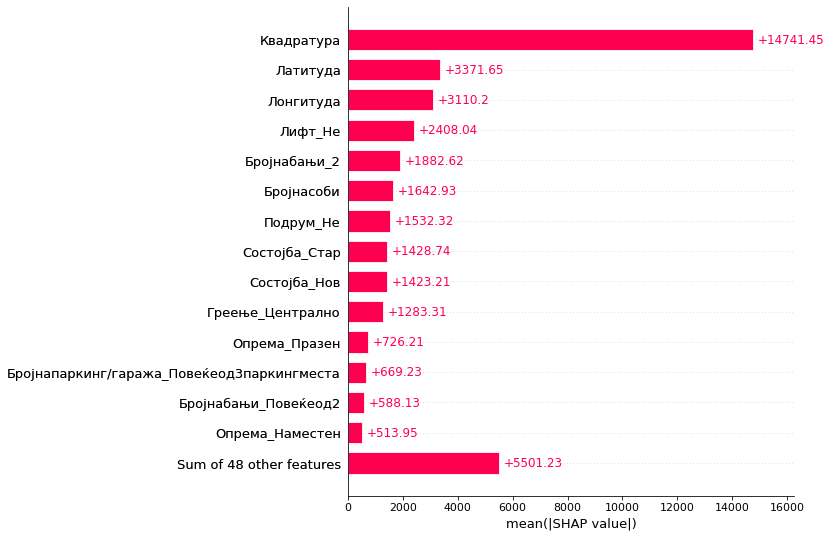

In [ ]:
explainer = shap.Explainer(model_onehotenc5)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0], max_display=15)
shap.plots.beeswarm(shap_values, max_display=15)
shap.summary_plot(shap_values, plot_type='violin', max_display=15)
shap.plots.bar(shap_values, max_display=15)

Model 6
--

<h2>LGBMRegressor</h2>

In [ ]:
lgbm = LGBMRegressor()

gsc = GridSearchCV(
            estimator=lgbm,
            param_grid={'num_leaves': [7, 14, 21, 28, 31, 50, 65],
                        'learning_rate': [0.03, 0.05, 0.10, 0.13, 0.15, 0.20, 0.25],
                        'max_depth': [3, 4, 5, 6, 8],
                        'n_estimators': [50, 100, 150, 200, 300],
                        'random_state' : [0]
                        },
            cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

gsc.fit(x, y)

print("Best score:", gsc.best_score_)
print("Best estimator:", gsc.best_estimator_)
print("Best parameters:", gsc.best_params_)

Fitting 3 folds for each of 1225 candidates, totalling 3675 fits
Best score: -10861.949305104114
Best estimator: LGBMRegressor(learning_rate=0.13, max_depth=4, n_estimators=200, num_leaves=7,
              random_state=0)
Best parameters: {'learning_rate': 0.13, 'max_depth': 4, 'n_estimators': 200, 'num_leaves': 7, 'random_state': 0}


In [39]:
model_onehotenc6 = LGBMRegressor(learning_rate=0.13, max_depth=4, n_estimators=200,
                       num_leaves=7, random_state=0)

model_onehotenc6.fit(X_train, Y_train)
y_pred = model_onehotenc6.predict(X_test)

print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_pred, Y_test))))
print("Mean Squared Error : " + str(np.sqrt(mean_squared_error(y_pred, Y_test))))
print("Mean Absolute Percentage error: " + str(mean_absolute_percentage_error(Y_test, y_pred)))
print("R2_score:" +str( r2_score(y_pred,Y_test)))

Mean Absolute Error : 101.51016916115739
Mean Squared Error : 15531.764683919628
Mean Absolute Percentage error: 0.1516114435731294
R2_score:0.6681857657867748


In [40]:
file_name = "/content/drive/MyDrive/lgbm_reg_flats_onehotenc.pkl"
# save
pickle.dump(model_onehotenc6, open(file_name, "wb"))

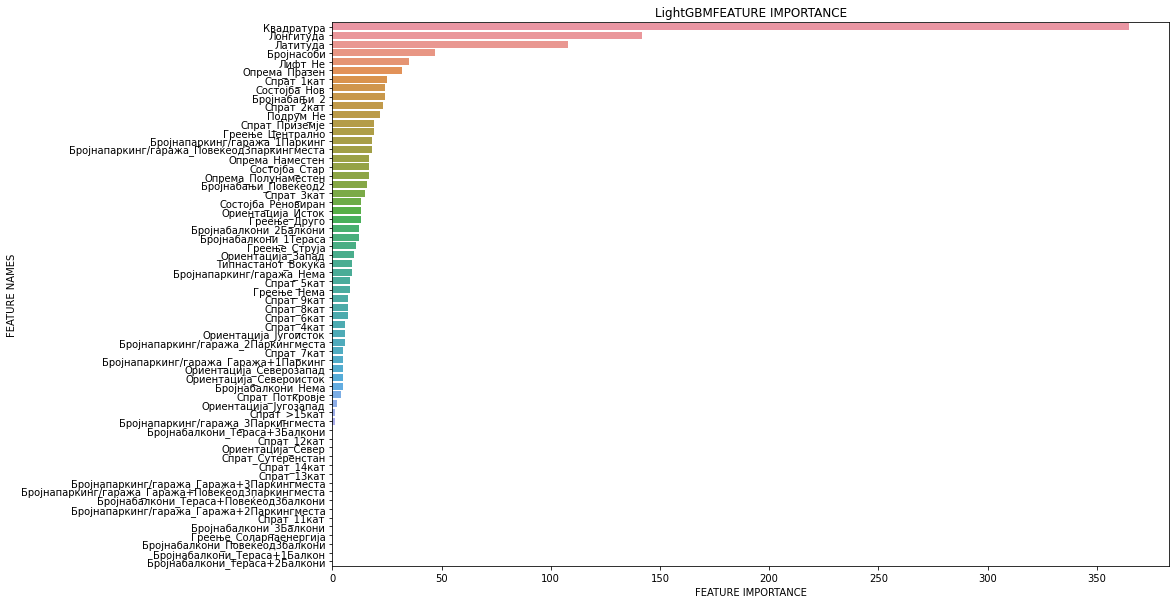

In [ ]:
plot_feature_importance(model_onehotenc6.feature_importances_, features, 'LightGBM')

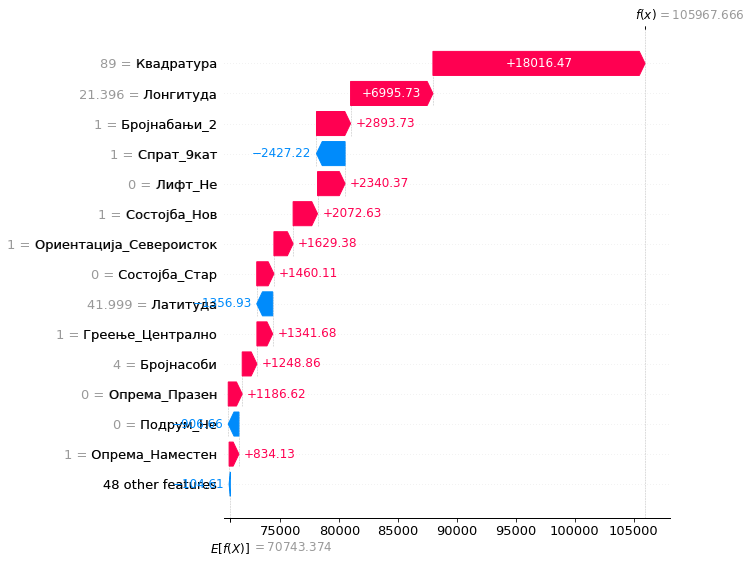

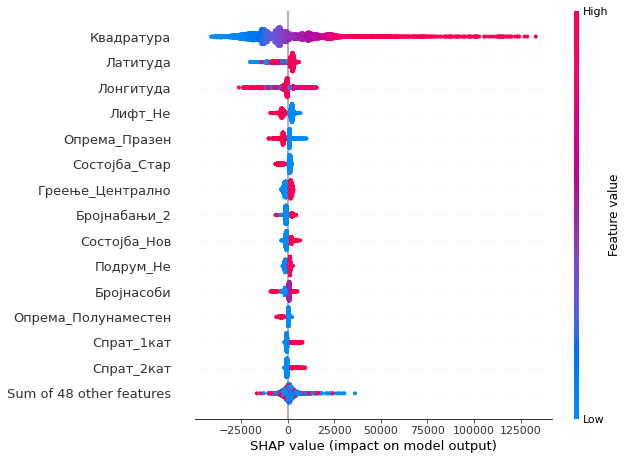

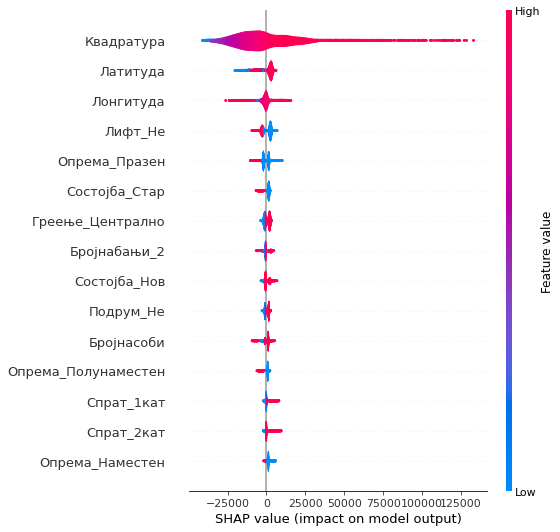

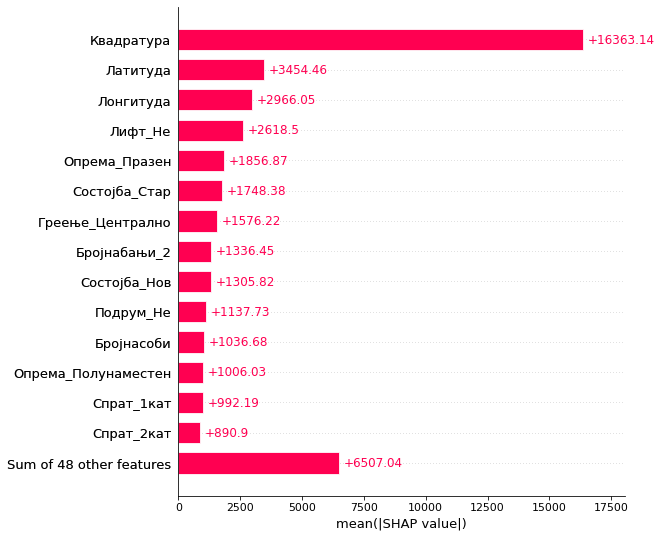

In [ ]:
explainer = shap.Explainer(model_onehotenc6)
shap_values = explainer(x)

shap.plots.waterfall(shap_values[0], max_display=15)
shap.plots.beeswarm(shap_values, max_display=15)
shap.summary_plot(shap_values, plot_type='violin', max_display=15)
shap.plots.bar(shap_values, max_display=15)

SUMMARY
--

In [ ]:
from sklearn import metrics
algorithms = []

algorithms.append(XGBRegressor(objective ='reg:squarederror', gamma = 0.0, colsample_bytree = 0.4, learning_rate = 0.25, min_child_weight=7, max_depth = 8, alpha = 2, n_estimators = 20))

algorithms.append(XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.2, min_child_weight=6, max_depth = 6, alpha = 2, n_estimators = 20, random_state=0))

algorithms.append(XGBRegressor(objective ='reg:squarederror', gamma = 0.0, colsample_bytree = 0.7, learning_rate = 0.24, min_child_weight=1, max_depth = 5, alpha = 2, n_estimators = 25))

algorithms.append(XGBRegressor(objective ='reg:squarederror', gamma = 0.0, colsample_bytree = 0.8, learning_rate = 0.22, min_child_weight=7, max_depth = 5, alpha = 2, n_estimators = 30))

algorithms.append(CatBoostRegressor(iterations=200, l2_leaf_reg=5, learning_rate=0.1, 
                           loss_function='MAE', depth=6, random_state=0, verbose=False))

algorithms.append(LGBMRegressor(learning_rate=0.13, max_depth=4, n_estimators=200,
                       num_leaves=7, random_state=0))

data = []

for algo in algorithms:

  algo.fit(X_train, Y_train)

  y_pred = algo.predict(X_test)

  data.append(({
        'Mean Absolute Error': np.sqrt(metrics.mean_absolute_error(y_pred, Y_test)),
        'Mean Absolute Percentage Error': metrics.mean_absolute_percentage_error(y_pred, Y_test),
        'R2 score': metrics.r2_score(y_pred, Y_test),
        'Mean Squared Error': np.sqrt(metrics.mean_squared_error(y_pred, Y_test))
        }))
  

results = pd.DataFrame(data=data, columns=['Mean Absolute Error', 'Mean Absolute Percentage Error', 'R2 score',
                                           'Mean Squared Error'],
                       index=['XGBRegressor1', 'XGBRegressor2', 
                              'XGBRegressor3', 'XGBRegressor4', 
                              'CatBoostRegressor', 'LGBMRegressor'])

results

,Mean Absolute Error,Mean Absolute Percentage Error,R2 score,Mean Squared Error
XGBRegressor1,102.395949,0.146168,0.622852,15992.887709
XGBRegressor2,102.191120,0.147631,0.623391,15960.823833
XGBRegressor3,102.225773,0.146675,0.628383,15806.232897
XGBRegressor4,102.235726,0.146328,0.644229,15936.063634
CatBoostRegressor,101.253155,0.145553,0.627311,15902.327682
LGBMRegressor,101.510169,0.144203,0.668186,15531.764684


Најдобри перформанси за податоците енкодирани со различни техники за различни карактеристики имаат моделите CatBoostRegressor и LGBMRegressor. Модел 7 (xgboost+kfold+randomizedsearch) исто така има многу добри перформанси со Кумулативна средна апсолутна грешка од 99.29707330218278

Model 7
--

<h2>XGBRegressor + KFold + RandomizedSearch</h2>

In [ ]:
y = onehotenc_flats['Цена']

In [ ]:
xgb = XGBRegressor()

param_dist = {"learning_rate": (0.05, 0.10, 0.15, 0.20, 0.25),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.7],
                        'objective':['reg:linear', 'reg:squarederror'],
                        }
reg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'neg_mean_absolute_error', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(x))
score = 0.0
kf = 0

for train_index, test_index in folds.split(x):
    X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    reg.fit(X_train, y_train)

    estimators.append(reg.best_estimator_)
    results[test_index] = reg.predict(X_test)
    score += np.sqrt(mean_absolute_error(y_test, results[test_index]))
    print("Mean Absolute error for fold ", kf, "is: ", np.sqrt(mean_absolute_error(y_test, results[test_index])))
    kf += 1
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  0 is:  98.7340917778189
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[20:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute error for fold  1 is:  99.01363451615182
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  2 is:  99.81837104001131
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  3 is:  98.33016248954763
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  4 is:  100.58910668738416


In [ ]:
print("Cummulative Mean Absolute Error: ", score)

Cummulative Mean Absolute Error:  99.29707330218278


In [ ]:
print("Best Random Estimators: ", estimators)

Best Random Estimators:  [XGBRegressor(colsample_bytree=0.7, gamma=0.0, max_depth=6, min_child_weight=5,
             objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.5, gamma=0.2, learning_rate=0.05, max_depth=8,
             min_child_weight=5), XGBRegressor(colsample_bytree=0.3, gamma=0.0, max_depth=6, min_child_weight=5,
             objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=8,
             min_child_weight=5, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.7, gamma=0.1, max_depth=5, min_child_weight=5,
             objective='reg:squarederror')]


Model 8
--

<h2>XGBRegressor + KFold + RandomizedSearch</h2>

In [ ]:
xgb = XGBRegressor()

param_dist = {"learning_rate": (0.01, 0.02, 0.05, 0.08, 0.10, 0.15, 0.20),
                        "max_depth": [ 5, 6, 7, 8],
                        "min_child_weight": [ 1, 3, 5, 6, 7],
                        "colsample_bytree":[ 0.2, 0.3, 0.4, 0.6, 0.7, 0.8],
                        'objective':['reg:squarederror'],
                        'n_estimators': [1, 5, 10, 15, 20, 25, 30],
                        'random_state' : [0]
                        }
reg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'neg_mean_absolute_error', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(x))
score = 0.0
kf = 1

for train_index, test_index in folds.split(x):
    X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    reg.fit(X_train, y_train)

    estimators.append(reg.best_estimator_)
    results[test_index] = reg.predict(X_test)
    score += np.sqrt(mean_absolute_error(y_test, results[test_index]))
    print("Mean Absolute error for fold ", kf, "is: ", np.sqrt(mean_absolute_error(y_test, results[test_index])))
    kf += 1
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  1 is:  102.384942181114
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  2 is:  100.22741334445587
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  3 is:  97.78569222321114
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  4 is:  101.5621183278882
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute error for fold  5 is:  100.64290673785999


In [ ]:
print("Cummulative Mean Absolute Error: ", score)

Cummulative Mean Absolute Error:  100.52061456290582


In [ ]:
print("Best Random Estimators: ", estimators)

Best Random Estimators:  [XGBRegressor(colsample_bytree=0.7, learning_rate=0.15, max_depth=6,
             n_estimators=30, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.6, learning_rate=0.2, max_depth=8,
             min_child_weight=7, n_estimators=30, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.6, learning_rate=0.2, max_depth=8,
             min_child_weight=3, n_estimators=30, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.6, learning_rate=0.15, max_depth=6,
             min_child_weight=3, n_estimators=30, objective='reg:squarederror'), XGBRegressor(colsample_bytree=0.4, learning_rate=0.2, max_depth=8,
             min_child_weight=3, n_estimators=20, objective='reg:squarederror')]
